# 1.0 Business Problem

House Rocket is a ficticious real state company. One of the challenges faced by this company is to find Real State deals within an available portfolio, that is, finding undervalued houses and selling them for a better price. Considering that this company doesn't have a specific niche, in others words, there is no  specific geographical location, client category or property type. 

Considering the context above this project seek to answer the following questions:

1. What properties should be bought by the company and for what price?

2. Once the properties are bought when is the best moment to sell them and for what price?

* id - Unique ID for each home sold
* date - Date of the home sale
* price - Price of each home sold
*    bedrooms - Number of bedrooms
*    bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
*    sqft_living - Square footage of the apartments interior living space
*    sqft_lot - Square footage of the land space
*   floors - Number of floors
*   waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
*   view - An index from 0 to 4 of how good the view of the property was
*   condition - An index from 1 to 5 on the condition of the apartment,
*    grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of        construction and design, and 11-13 have a high quality level of construction and design.
*    sqft_above - The square footage of the interior housing space that is above ground level
*    sqft_basement - The square footage of the interior housing space that is below ground level
*    yr_built - The year the house was initially built
*    yr_renovated - The year of the house’s last renovation
*    zipcode - What zipcode area the house is in
*    lat - Lattitude
*    long - Longitude
*    sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
*   sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

# 0.0. Importing libraries

In [1]:
import pandas as pd
import numpy  as np
import os  
import random

from IPython.core.display import HTML
from IPython.display      import Image
from tqdm.notebook        import tqdm_notebook
import tqdm
%load_ext autotime

import matplotlib.gridspec as gridspec
import matplotlib.pyplot   as plt
import plotly.express      as px
import seaborn             as sns
  
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from category_encoders     import TargetEncoder

from boruta import BorutaPy
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble     import RandomForestRegressor
from sklearn.metrics      import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from xgboost              import XGBRegressor
import pickle


time: 3.78 s (started: 2022-07-31 13:25:32 +01:00)


### Helper Functions

In [2]:
# sets figures size
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 12
    # display(HTML('<style>.container{width:100% :important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set
    
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'price'], axis=1 ) 
        ytraining = training['price']

        # validation
        xvalidation = validation.drop( ['date', 'price'], axis=1 )
        yvalidation = validation['price']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

# add patches to graphs
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

def feature_dist_clas(df, col):
    
    fig, axes = plt.subplots(1, 4, figsize = (25, 5))
    palette = ["#0EB8F1", "#F1480F"]
    
    sns.histplot(x = col, data = df, ax = axes[0], palette = palette, edgecolor="black", linewidth=0.5)
    sns.kdeplot(x = col, data = df, fill = True, ax = axes[1], palette = palette, linewidth = 2)
    sns.boxplot(y = col, data = df, x = [""] * len(df), ax = axes[2], 
                palette = palette, linewidth = 2, flierprops = dict(marker = "x", markersize = 3.5))
    
    sns.violinplot(y = col, data = df, x = [""] * len(df), ax = axes[3], palette = palette)
    
    fig.suptitle("For Feature:  " + col)
    axes[0].set_title("Histogram For Feature " + col)
    axes[1].set_title("KDE Plot For Feature " + col)   
    axes[2].set_title("Boxplot For Feature " + col)   
    axes[3].set_title("Violinplot For Feature " + col)   
    
    for ax in axes:
        ax.set_facecolor("#C7D3D4FF")
        ax.grid(linewidth = 0.25)

def plots(dframe, x, y):
    fig = plt.figure(figsize=(12, 20))
    gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

    ax1 = fig.add_subplot(gs[0, :2]) # linha, coluna
    ax2 = fig.add_subplot(gs[1, 1]) 
    ax3 = fig.add_subplot(gs[1, 0]) 

    new_df = dframe.groupby(x, as_index=False)[y].median()

    p = sns.barplot(x=x, y=y, order=new_df.sort_values(y, ascending=False)[x], data=new_df, ax=ax1)
    sns.heatmap(new_df.corr(method='pearson'), annot=True, ax=ax2)
    sns.regplot(x=x, y=y, data=new_df, ax=ax3)

def cat_plots(dframe, x, y):
    
    new_df = dframe.groupby(x, as_index=False)[y].median()
    df_dummies = pd.get_dummies(dframe[x])
    df_dummies = pd.concat([dframe[y], df_dummies], axis=1)
    correlation = df_dummies.corr(method='pearson')

    plt.figure(figsize=(10, 12))
    plt.subplot(2,1,1)
    p = sns.barplot(x=x, y=y, order=new_df.sort_values(y, ascending=False)[x], data=new_df);
    show_values(p);

    plt.subplot(2,1,2)
    sns.heatmap(correlation, annot=True);


def mean_percentage_error(y, yhat):
    return np.mean(((y - yhat)/y))


def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

            

time: 0 ns (started: 2022-07-31 13:25:36 +01:00)


In [3]:
jupyter_settings()

# sets format to suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Populating the interactive namespace from numpy and matplotlib
time: 15 ms (started: 2022-07-31 13:25:36 +01:00)


c:\Users\Natalia\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1.0. Data Understanding 

## 1.1. Loading data

In [4]:
df = pd.read_csv( "C:/Users/Natalia/Documents/pycharm_repo/kc_house_data.csv" )
df.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15
0  7129300520  20141013T000000 221900.00         3       1.00         1180      5650    1.00           0     0          3      7        1180              0      1955             0    98178 47.51 -122.26           1340        5650
1  6414100192  20141209T000000 538000.00         3       2.25         2570      7242    2.00           0     0          3      7        2170            400      1951          1991    98125 47.72 -122.32           1690        7639
2  5631500400  20150225T000000 180000.00         2       1.00          770     10000    1.00           0     0          3      6         770              0      1933             0    98028 47.74 -122.23           2720        8062
3  2487200875  20141209T000000 604000.00         4       3.00         1960      5000    1.00           0     0          5      7        1050            910      1965             0    98136 47.52 -122.39           1360        5000
4  1954400510  20150218T000000 510000.00         3       2.00         1680      8080    1.00           0     0          3      8        1680              0      1987             0    98074 47.62 -122.05           1800        7503

time: 156 ms (started: 2022-07-31 13:25:36 +01:00)


In [5]:
df1 = df.copy()

time: 0 ns (started: 2022-07-31 13:25:36 +01:00)


## 1.2. Data Description

###  1.2.1. Data dimension

In [6]:
df1.shape

(21613, 21)

time: 15 ms (started: 2022-07-31 13:25:36 +01:00)


### 1.2.2. Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

### 1.2.3. Descriptive Statistics

In [8]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

#### Numerical attributes
# Central tendencies
c1 = pd.DataFrame(num_attributes.apply(np.mean)).T
c2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate

m = pd.concat([d2, d3, d4, c1, c2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis']

m

attributes        min           max         range          mean        median           std  skewness  kurtosis
0              id 1000102.00 9900000190.00 9899000088.00 4580301520.86 3904930410.00 2876499023.43      0.24     -1.26
1           price   75000.00    7700000.00    7625000.00     540088.14     450000.00     367118.70      4.02     34.59
2        bedrooms       0.00         33.00         33.00          3.37          3.00          0.93      1.97     49.06
3       bathrooms       0.00          8.00          8.00          2.11          2.25          0.77      0.51      1.28
4     sqft_living     290.00      13540.00      13250.00       2079.90       1910.00        918.42      1.47      5.24
5        sqft_lot     520.00    1651359.00    1650839.00      15106.97       7618.00      41419.55     13.06    285.08
6          floors       1.00          3.50          2.50          1.49          1.50          0.54      0.62     -0.48
7      waterfront       0.00          1.00          1.00          0.01          0.00          0.09     11.39    127.63
8            view       0.00          4.00          4.00          0.23          0.00          0.77      3.40     10.89
9       condition       1.00          5.00          4.00          3.41          3.00          0.65      1.03      0.53
10          grade       1.00         13.00         12.00          7.66          7.00          1.18      0.77      1.19
11     sqft_above     290.00       9410.00       9120.00       1788.39       1560.00        828.07      1.45      3.40
12  sqft_basement       0.00       4820.00       4820.00        291.51          0.00        442.56      1.58      2.72
13       yr_built    1900.00       2015.00        115.00       1971.01       1975.00         29.37     -0.47     -0.66
14   yr_renovated       0.00       2015.00       2015.00         84.40          0.00        401.67      4.55     18.70
15        zipcode   98001.00      98199.00        198.00      98077.94      98065.00         53.50      0.41     -0.85
16            lat      47.16         47.78          0.62         47.56         47.57          0.14     -0.49     -0.68
17           long    -122.52       -121.31          1.20       -122.21       -122.23          0.14      0.89      1.05
18  sqft_living15     399.00       6210.00       5811.00       1986.55       1840.00        685.38      1.11      1.60
19     sqft_lot15     651.00     871200.00     870549.00      12768.46       7620.00      27303.55      9.51    150.76

time: 94 ms (started: 2022-07-31 13:25:36 +01:00)


## 1.3. Data Cleaning

### 1.3.1 Duplicated values

In [9]:
df1['id'].duplicated().sum()

177

time: 15 ms (started: 2022-07-31 13:25:36 +01:00)


In [10]:
df1['id'] = df1['id'].drop_duplicates(keep='last')

time: 0 ns (started: 2022-07-31 13:25:36 +01:00)


### 1.3.3 Missing Values

In [11]:
nan_cols = df1.isna().sum()
nan_cols[nan_cols>0]

id    177
dtype: int64

time: 15 ms (started: 2022-07-31 13:25:36 +01:00)


In [12]:
zero_values = (df == 0).sum()
zero_values[zero_values > 0]

bedrooms            13
bathrooms           10
waterfront       21450
view             19489
sqft_basement    13126
yr_renovated     20699
dtype: int64

time: 16 ms (started: 2022-07-31 13:25:37 +01:00)


In [13]:
df1 = df1[df1['bedrooms'] != 0]

time: 0 ns (started: 2022-07-31 13:25:37 +01:00)


In [14]:
df1 = df1[df1['bathrooms'] != 0]

time: 15 ms (started: 2022-07-31 13:25:37 +01:00)


### 1.3.4. Data inconsistencies

In [15]:
df1[df1['sqft_living'] > df1['sqft_lot']].head()

id       date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15
63  9528102996.00 2014-12-07 549000.00         3       1.75         1540      1044    3.00           0     0          3      8        1540              0      2014             0    98115 47.68 -122.32           1580        3090
116 3362400431.00 2014-06-26 518500.00         3       3.50         1590      1102    3.00           0     0          3      8        1590              0      2010             0    98103 47.68 -122.35           1620        3166
175 7234600798.00 2015-02-10 425000.00         3       2.50         1120      1100    2.00           0     0          3      8         820            300      2008             0    98122 47.61 -122.31           1590        1795
406 7821200390.00 2014-08-06 450000.00         3       2.00         1290      1213    3.00           0     0          3      8        1290              0      2001             0    98103 47.66 -122.34           1290        3235
547 7899800860.00 2015-03-19 259950.00         2       2.00         1070       649    2.00           0     0          3      9         720            350      2008             0    98106 47.52 -122.36           1070         928

time: 31 ms (started: 2022-07-31 13:25:37 +01:00)


In [16]:
df1 = df1[df1['sqft_living'] <= df1['sqft_lot']]

time: 16 ms (started: 2022-07-31 13:25:37 +01:00)


### 1.3.5. Filter out outliers

In [17]:
numerics = ['int64', 'float64']
numeric = df1.select_dtypes(include=numerics)
Q1 = numeric.quantile(0.25)
Q3 = numeric.quantile(0.75)
IQR = Q3 - Q1
outliers = ((numeric <= (Q1 - 1.5 * IQR)) | (numeric >= (Q3 + 1.5 * IQR))).sum()
outliers[outliers>0]

price             1101
bedrooms           523
bathrooms          396
sqft_living        545
sqft_lot          2408
floors               1
waterfront       20809
view             20809
condition           29
grade             1880
sqft_above         575
sqft_basement      439
yr_renovated     20809
long               254
sqft_living15      479
sqft_lot15        2194
dtype: int64

time: 94 ms (started: 2022-07-31 13:25:37 +01:00)


In [18]:
df1 = df1[df1['bedrooms'] != 33].reset_index(drop=True)

time: 0 ns (started: 2022-07-31 13:25:37 +01:00)


In [19]:
df1.shape

(20808, 21)

time: 16 ms (started: 2022-07-31 13:25:37 +01:00)


In [20]:
''' Detection '''
# IQR
Q1 = np.percentile(df1['price'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df1['price'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", df1.shape)
 
# Upper bound
upper = np.where(df1['price'] >= (Q3+3.5*IQR))
# Lower bound
lower = np.where(df1['price'] <= (Q1-1.5*IQR))
 
''' Removing Outliers '''
df1.drop(upper[0], inplace = True)
df1.drop(lower[0], inplace = True)
 
print("New Shape: ", df1.shape)

Old Shape:  (20808, 21)
New Shape:  (20521, 21)
time: 31 ms (started: 2022-07-31 13:25:37 +01:00)


# 2.0. Feature Engineering

### 2.1. Mind Mapping of Hipothesis

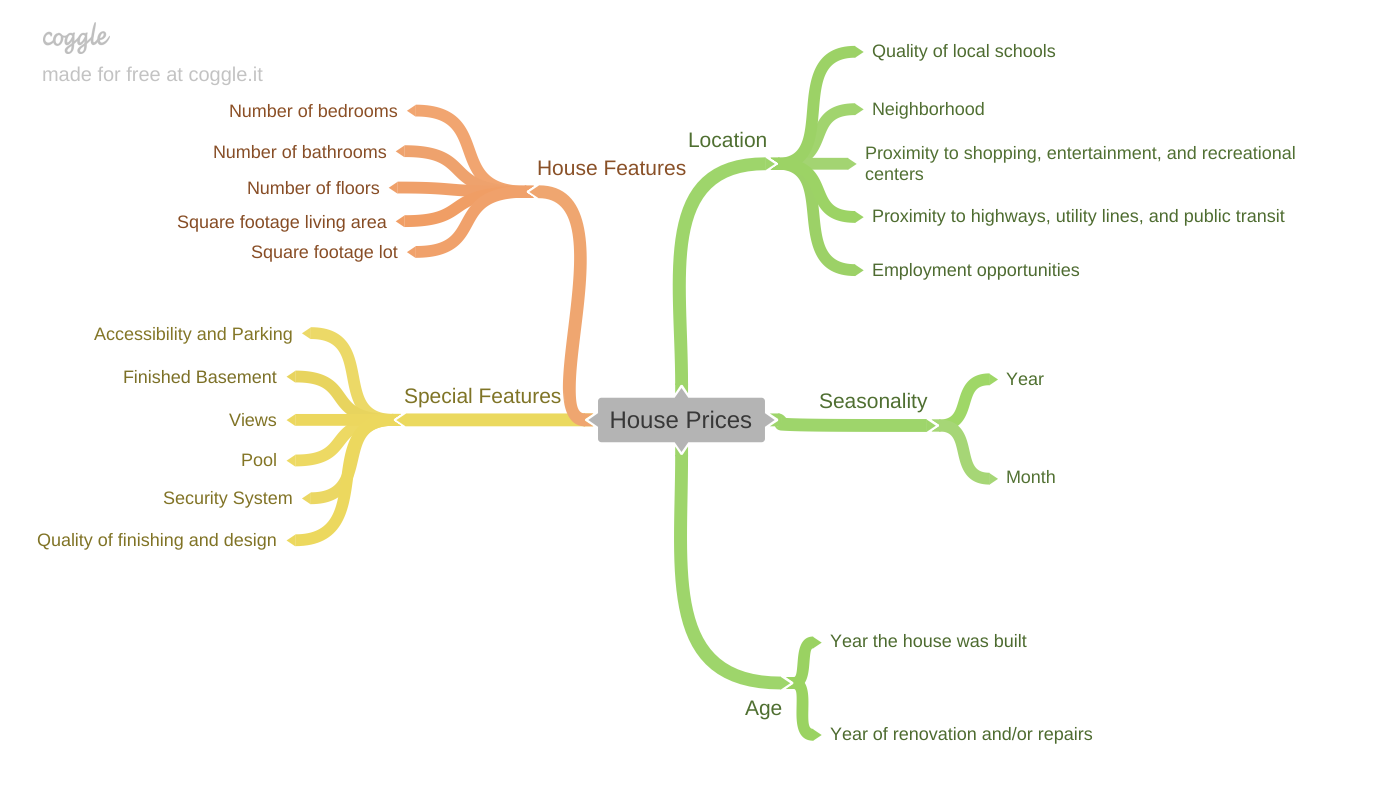

time: 16 ms (started: 2022-07-31 13:25:37 +01:00)


In [21]:
Image("C:/Users/Natalia/Desktop/House_Prices.png")

### 2.2. Hypothesis

#### 2.1.1. Hypothesis house features

**1.** Houses with more bedrooms should be more expensive.

**2.** Houses with more bathrooms should be more expensive.

**3.** Houses with more number of floors should be more expensive.

**4.** Houses with more living area square footage shoulbe be more expensive 

**5.** Houses with more lot square footage should be more expensive

#### 2.1.2. Hypothesis house special features

**1.** Houses with a acessibility and parking should be more expensive

**2.** Houses with a basement should be more expensive

**3.** Houses with waterview should be more expensive

**4.** Houses with a pool should be more expensive

**5.** Houses with security system should be more expensive

**6.** Houses with better quality of finishing and design should be more expensive.


#### 2.1.3. Hypothesis house age

**1.** Older houses should be cheaper

**2.** Older houses renovated should be more expensive than houses built about the same year but have not been renovated

**3** Houses in better conditions should be more expensive

#### 2.1.4. Hypothesis seasonality

**1.** House prices increase during winter

**2.** House prices increase during summer

#### 2.1.5. Hypothesis location

**1.** House prices varies depending on the location

### 2.3. Final list of hypothesis

**1.** Houses with more bedrooms should be more expensive.

**2.** Houses with more bathrooms should be more expensive.

**3.** Houses with more number of floors should be more expensive.

**4.** Houses with more living area square footage should be be more expensive (obviously the price/sqft will increase since it's proportional to the size of the house)

**5.** Houses with more lot square footage should be more expensive

**6.** Houses with a basement should be more expensive

**7.** Houses with waterview should be more expensive

**8.** Houses with better quality of finishing and design should be more expensive.

**9.** Older houses should be cheaper

**10.** Older houses renovated should be more expensive than houses built about the same year but have not been renovated

**11.** Houses in better conditions should be more expensive

**12.** House prices increase during winter

**13.** House prices increase during summer

### 2.3. Feature Engineering

In [22]:
df2 = df1.copy()

time: 0 ns (started: 2022-07-31 13:25:38 +01:00)


In [23]:
# year
df2['yr_sale'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# basement
df2['basement'] = df2.apply(lambda x: 'basement' if x['sqft_basement'] > 0 else 'no_basement', axis=1)

#renovation
df2['renovated'] = df2.apply(lambda x: 'not_renovated' if x['yr_renovated'] == 0 else 'renovated', axis=1)

# month and year
df2['mth-yr_sale'] = df2['date'].dt.to_period('M')

# seasons 2014
start_spring_2014 = pd.to_datetime([1], unit='D', origin=pd.Timestamp('2014-03-01'))
end_spring_2014 = pd.to_datetime([31], unit='D', origin=pd.Timestamp('2014-05-01'))

start_summer_2014 = pd.to_datetime([1], unit='D', origin=pd.Timestamp('2014-06-01'))
end_summer_2014 = pd.to_datetime([31], unit='D', origin=pd.Timestamp('2014-08-01'))

start_fall_2014 = pd.to_datetime([1], unit='D', origin=pd.Timestamp('2014-09-01'))
end_fall_2014 = pd.to_datetime([30], unit='D', origin=pd.Timestamp('2014-11-01'))

start_winter_2014 = pd.to_datetime([1], unit='D', origin=pd.Timestamp('2014-12-01'))
end_winter_2014 = pd.to_datetime([29], unit='D', origin=pd.Timestamp('2015-02-01'))

# seasons 2015

start_spring_2015 = pd.to_datetime([1], unit='D', origin=pd.Timestamp('2015-03-01'))
end_spring_2015 = pd.to_datetime([31], unit='D', origin=pd.Timestamp('2015-05-01'))

start_summer_2015 = pd.to_datetime([1], unit='D', origin=pd.Timestamp('2015-06-01'))
end_summer_2015 = pd.to_datetime([31], unit='D', origin=pd.Timestamp('2015-08-01'))

start_fall_2015 = pd.to_datetime([1], unit='D', origin=pd.Timestamp('2015-09-01'))
end_fall_2015 = pd.to_datetime([30], unit='D', origin=pd.Timestamp('2015-11-01'))

start_winter_2015 = pd.to_datetime([1], unit='D', origin=pd.Timestamp('2015-12-01'))
end_winter_2015 = pd.to_datetime([29], unit='D', origin=pd.Timestamp('2016-02-01'))

df2['season_of_sale'] = df2.apply(lambda x: 'spring2014' if x['date']   >= start_spring_2014 and x['date'] <= end_spring_2014 else
                                            'summer2014' if x['date'] >= start_summer_2014 and x['date'] <= end_summer_2014    else 
                                            'fall2014'   if x['date']   >= start_fall_2014 and x['date']   <= end_fall_2014   else
                                            'winter2014' if x['date'] >= start_winter_2014 and x['date'] <= end_winter_2014  else
                                            'spring2015' if x['date']   >= start_spring_2015 and x['date'] <= end_spring_2015 else
                                            'summer2015' if x['date'] >= start_summer_2015 and x['date'] <= end_summer_2015    else
                                            'fall2015'   if x['date']   >= start_fall_2015 and x['date']   <= end_fall_2015   else 'winter2015',
                                             axis=1)


df2['zipcode'] = df2['zipcode'].apply(lambda x: str(x))

df2.head()

C:\Users\Natalia\AppData\Local\Temp/ipykernel_12900/2604703269.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


id       date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated zipcode   lat    long  sqft_living15  sqft_lot15  yr_sale  month  week_of_year     basement      renovated mth-yr_sale season_of_sale
0 7129300520.00 2014-10-13 221900.00         3       1.00         1180      5650    1.00           0     0          3      7        1180              0      1955             0   98178 47.51 -122.26           1340        5650     2014     10            42  no_basement  not_renovated     2014-10       fall2014
1 6414100192.00 2014-12-09 538000.00         3       2.25         2570      7242    2.00           0     0          3      7        2170            400      1951          1991   98125 47.72 -122.32           1690        7639     2014     12            50     basement      renovated     2014-12     winter2014
2 5631500400.00 2015-02-25 180000.00         2       1.00          770     10000    1.00           0     0          3      6         770              0      1933             0   98028 47.74 -122.23           2720        8062     2015      2             9  no_basement  not_renovated     2015-02     winter2014
3 2487200875.00 2014-12-09 604000.00         4       3.00         1960      5000    1.00           0     0          5      7        1050            910      1965             0   98136 47.52 -122.39           1360        5000     2014     12            50     basement  not_renovated     2014-12     winter2014
4 1954400510.00 2015-02-18 510000.00         3       2.00         1680      8080    1.00           0     0          3      8        1680              0      1987             0   98074 47.62 -122.05           1800        7503     2015      2             8  no_basement  not_renovated     2015-02     winter2014

time: 7.8 s (started: 2022-07-31 13:25:38 +01:00)


# 3.0. Step 3 - Variable Filtering

In [24]:
df3 = df2.copy()

time: 16 ms (started: 2022-07-31 13:25:45 +01:00)


### 3.1. Rows Filtering

### 3.2. Columns Selection

In [25]:
# drop irrelevant columns
df3 = df3.drop(columns=['lat', 'long'], axis=1)

time: 0 ns (started: 2022-07-31 13:25:46 +01:00)


# 4.0. Step 4 - Exploratory data Analysis

In [26]:
df4 = df3.copy()

time: 0 ns (started: 2022-07-31 13:25:46 +01:00)


### 4.1. Univariate Analysis

#### 4.1.1. Response Variable 

<AxesSubplot:xlabel='price', ylabel='Count'>

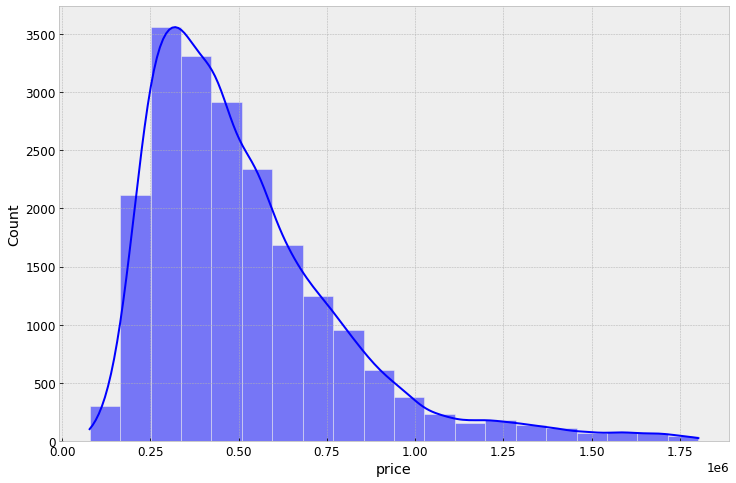

time: 828 ms (started: 2022-07-31 13:25:46 +01:00)


In [27]:
plt.figure(figsize=(12, 8))

sns.histplot(data=df4, x="price", kde=True, bins=20)

In [28]:
df4['view'].value_counts(ascending=True)

4      231
1      310
3      463
2      897
0    18620
Name: view, dtype: int64

time: 0 ns (started: 2022-07-31 13:25:47 +01:00)


#### 4.1.2. Numerical Variable

<AxesSubplot:xlabel='sqft_lot15', ylabel='Count'>

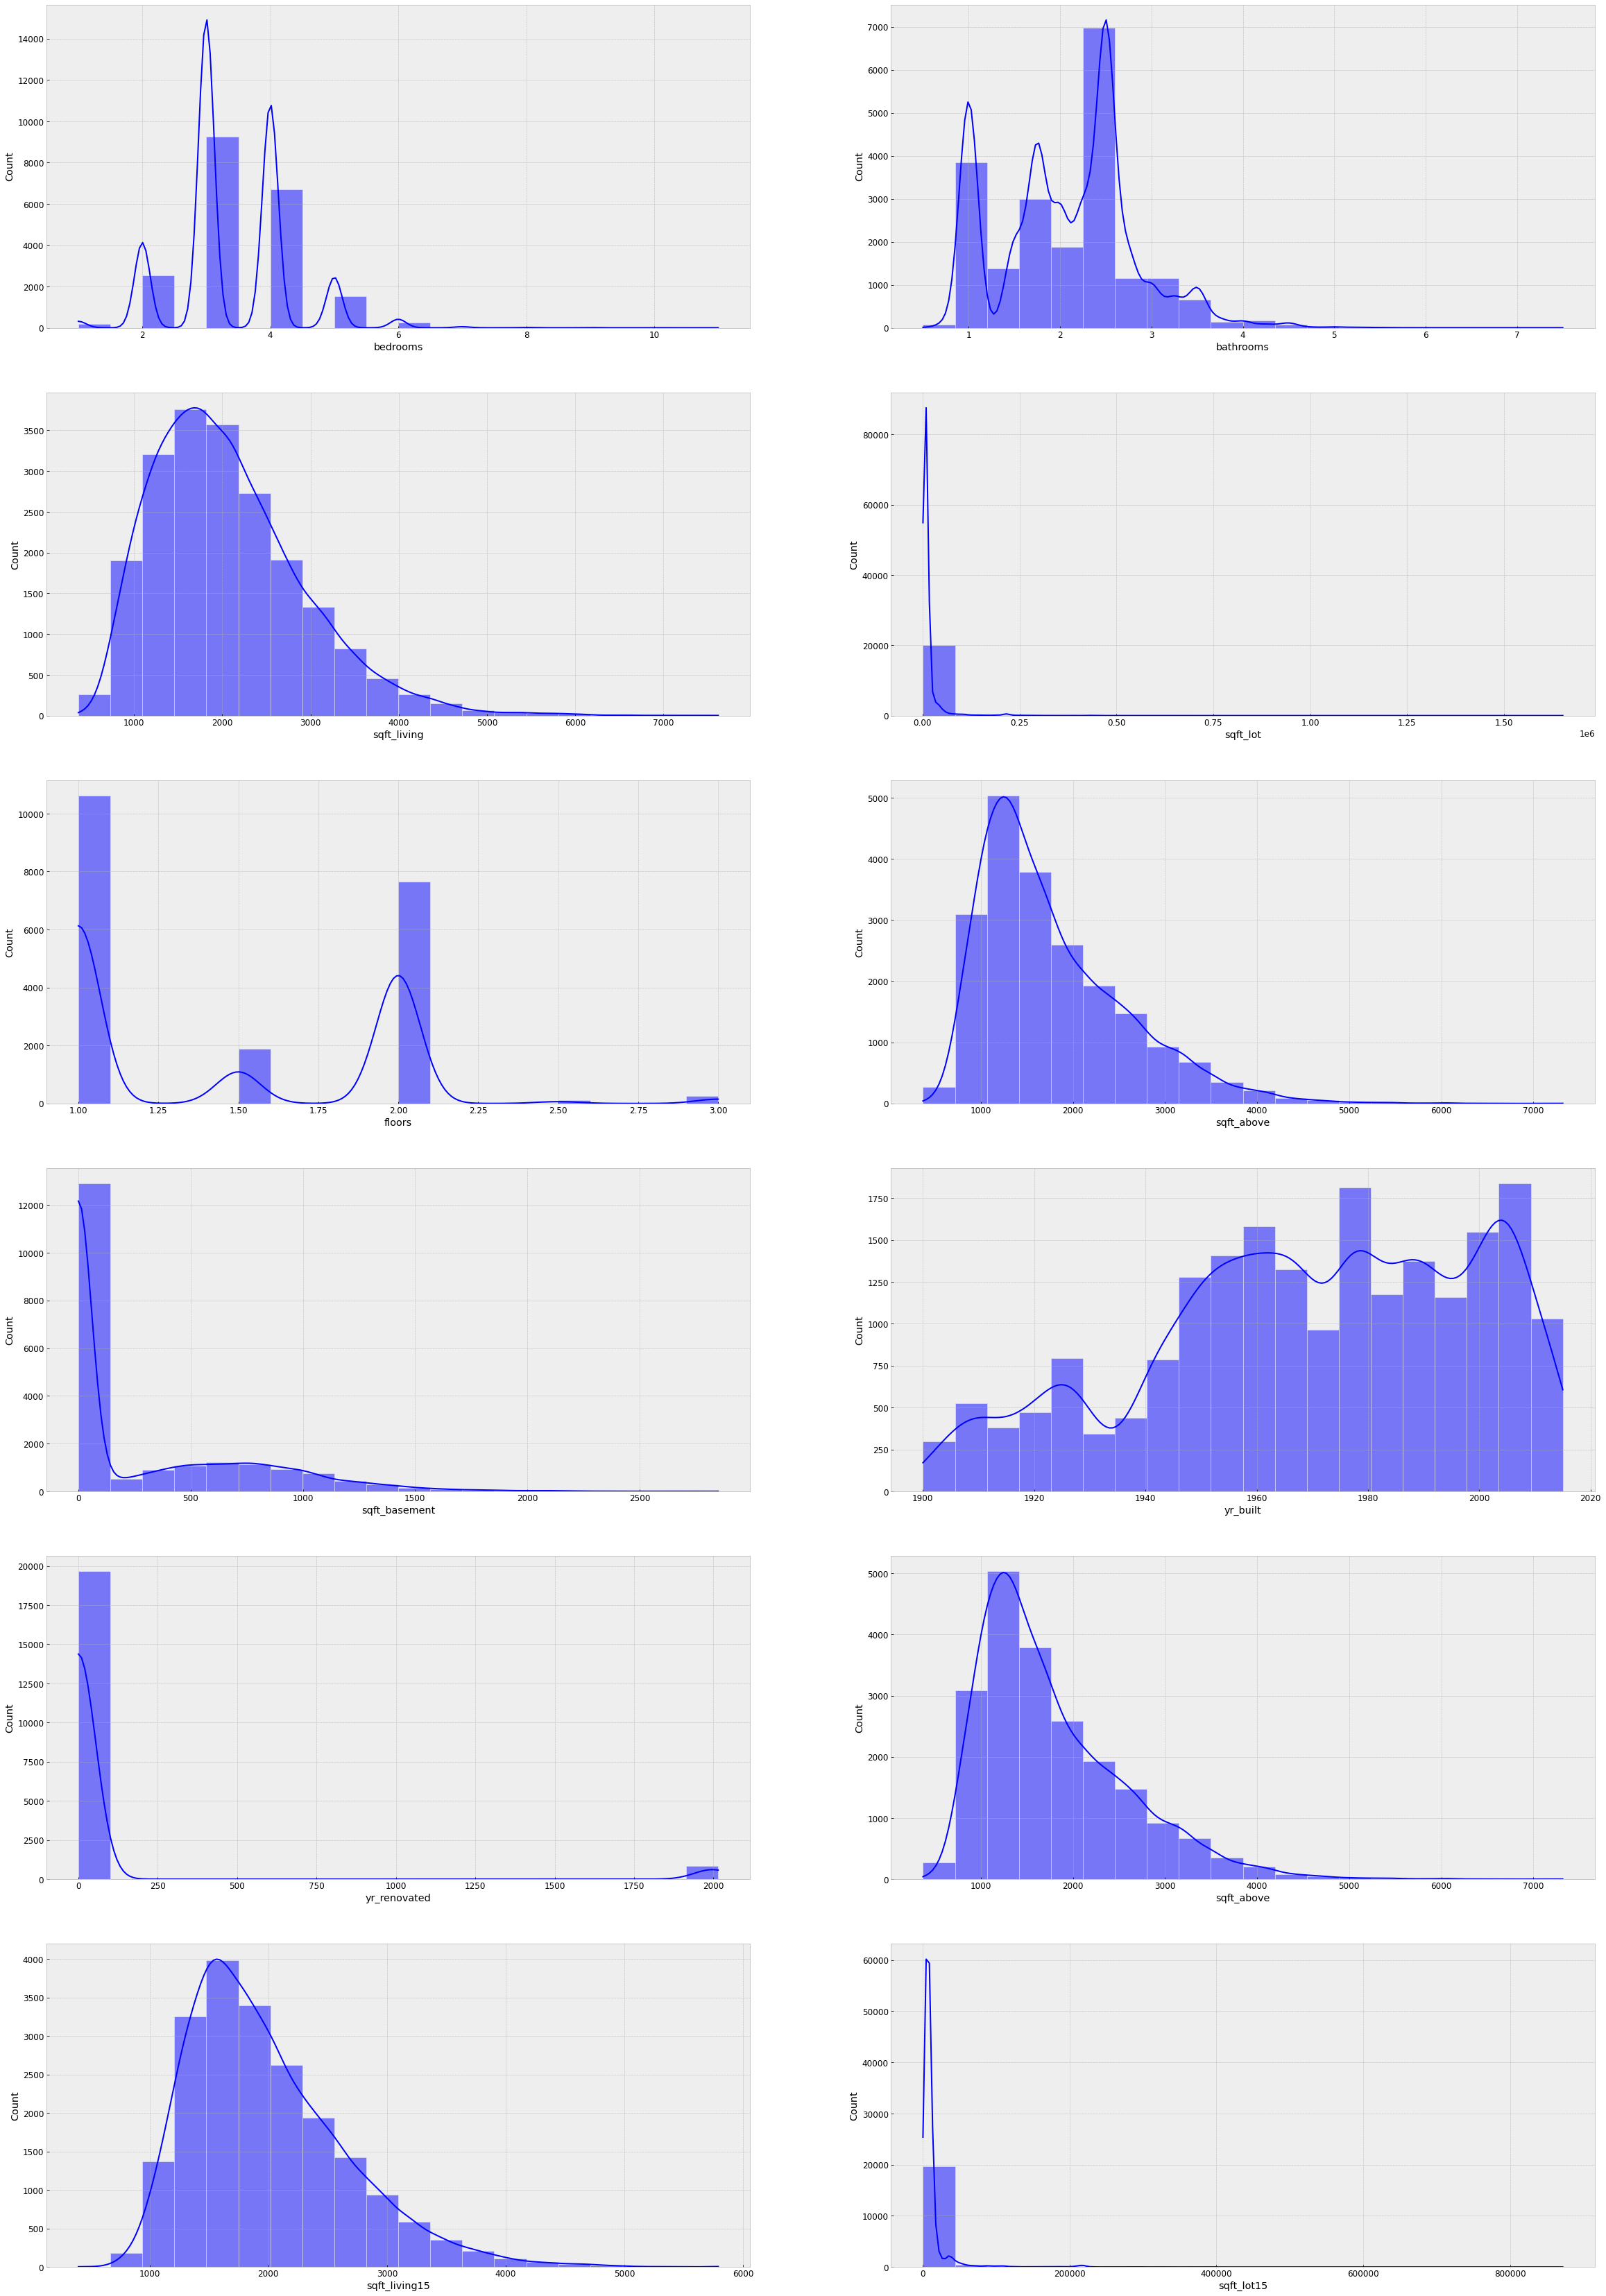

time: 6.48 s (started: 2022-07-31 13:25:47 +01:00)


In [29]:
#define dimensions of subplots (rows, columns)
fig = plt.figure(figsize=(40, 60))
gs = gridspec.GridSpec(ncols=2, nrows=6, figure=fig)

ax1 = fig.add_subplot(gs[0, 0]) # linha, coluna
ax2 = fig.add_subplot(gs[0, 1]) 
ax3 = fig.add_subplot(gs[1, 0]) 
ax4 = fig.add_subplot(gs[1, 1]) 
ax5 = fig.add_subplot(gs[2, 0]) 
ax6 = fig.add_subplot(gs[2, 1]) 
ax7 = fig.add_subplot(gs[3, 0]) 
ax8 = fig.add_subplot(gs[3, 1]) 
ax9 = fig.add_subplot(gs[4, 0]) 
ax10 = fig.add_subplot(gs[4, 1]) 
ax11 = fig.add_subplot(gs[5, 0]) 
ax12 = fig.add_subplot(gs[5, 1]) 


sns.histplot(data=df4, x="bedrooms", kde=True, bins=20, ax=ax1)
sns.histplot(data=df4, x="bathrooms", kde=True, bins=20, ax=ax2)
sns.histplot(data=df4, x="sqft_living", kde=True, bins=20, ax=ax3)
sns.histplot(data=df4, x="sqft_lot", kde=True, bins=20, ax=ax4)
sns.histplot(data=df4, x="floors", kde=True, bins=20, ax=ax5)
sns.histplot(data=df4, x="sqft_above", kde=True, bins=20, ax=ax6)
sns.histplot(data=df4, x="sqft_basement", kde=True, bins=20, ax=ax7)
sns.histplot(data=df4, x="yr_built", kde=True, bins=20, ax=ax8)
sns.histplot(data=df4, x="yr_renovated", kde=True, bins=20, ax=ax9)
sns.histplot(data=df4, x="sqft_above", kde=True, bins=20, ax=ax10)
sns.histplot(data=df4, x="sqft_living15", kde=True, bins=20, ax=ax11)
sns.histplot(data=df4, x="sqft_lot15", kde=True, bins=20, ax=ax12)


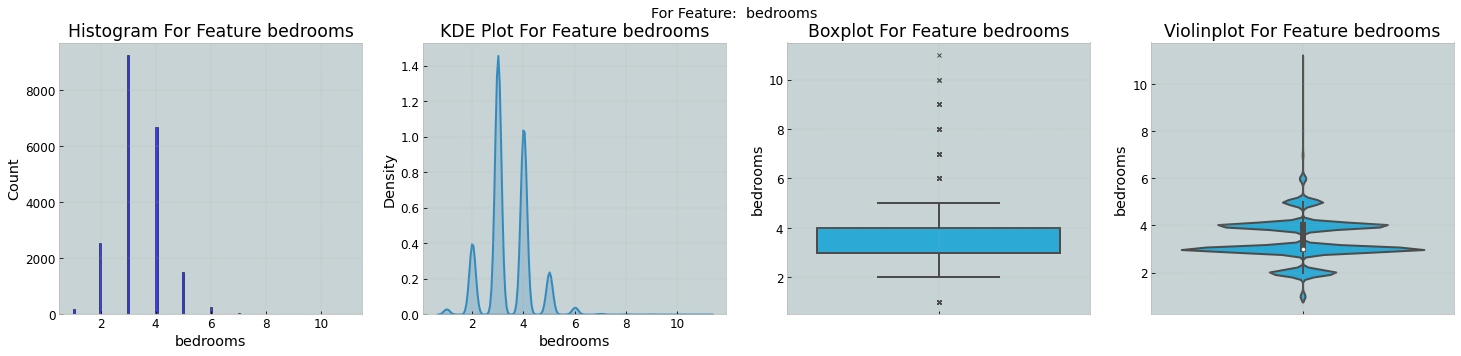

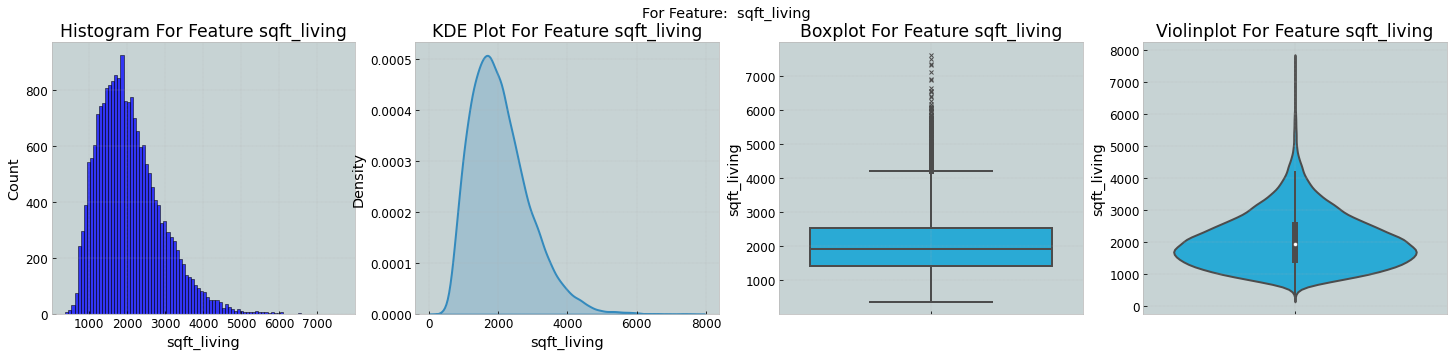

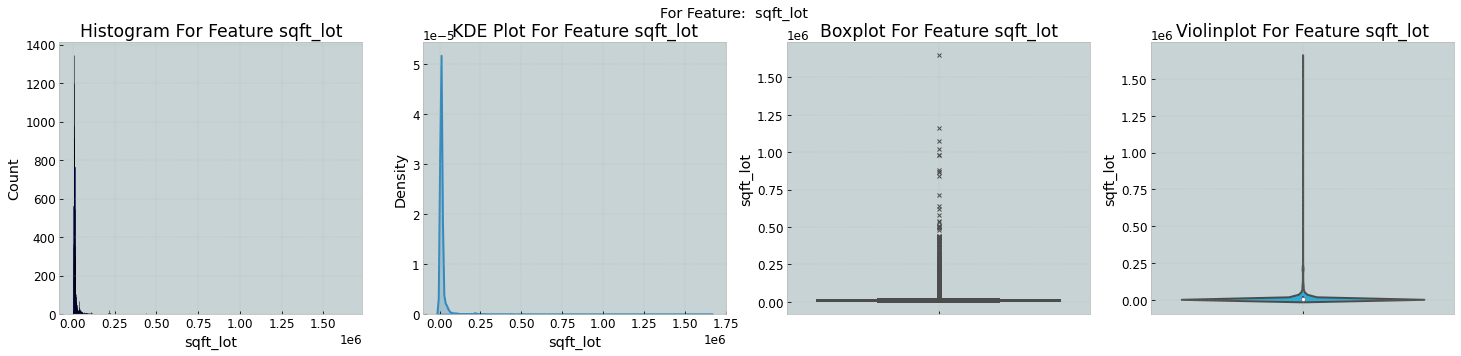

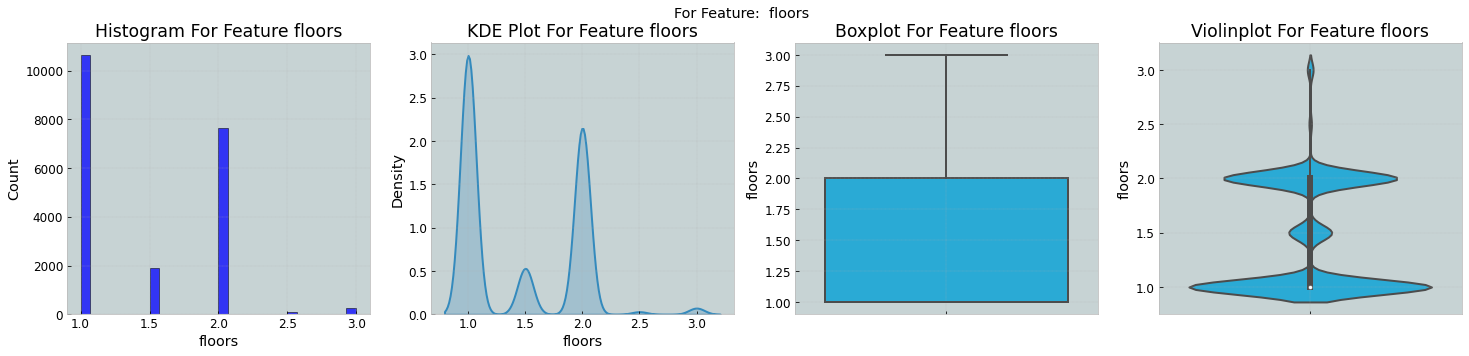

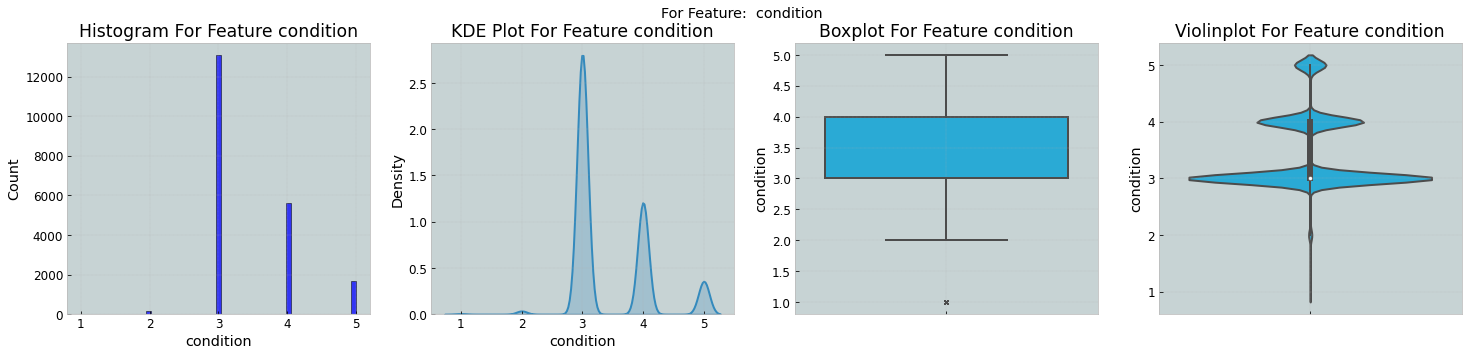

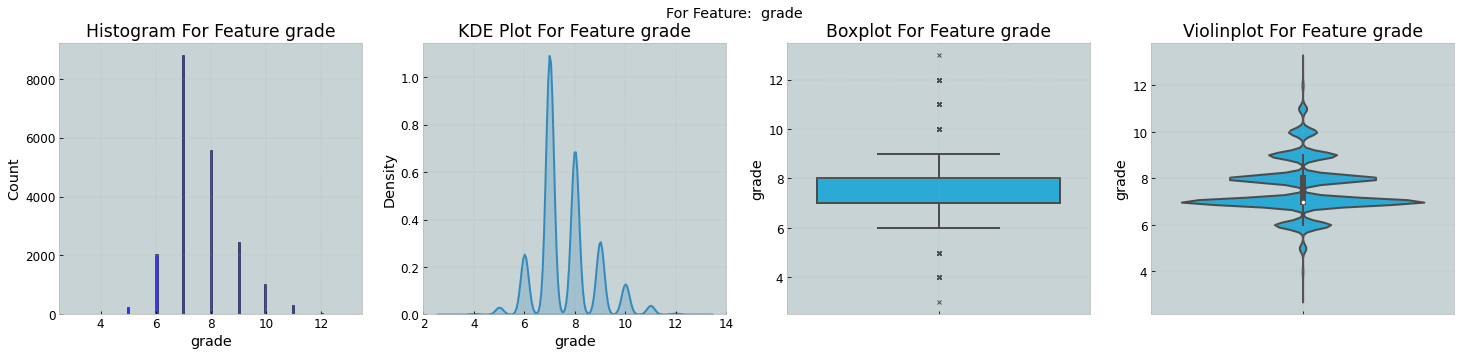

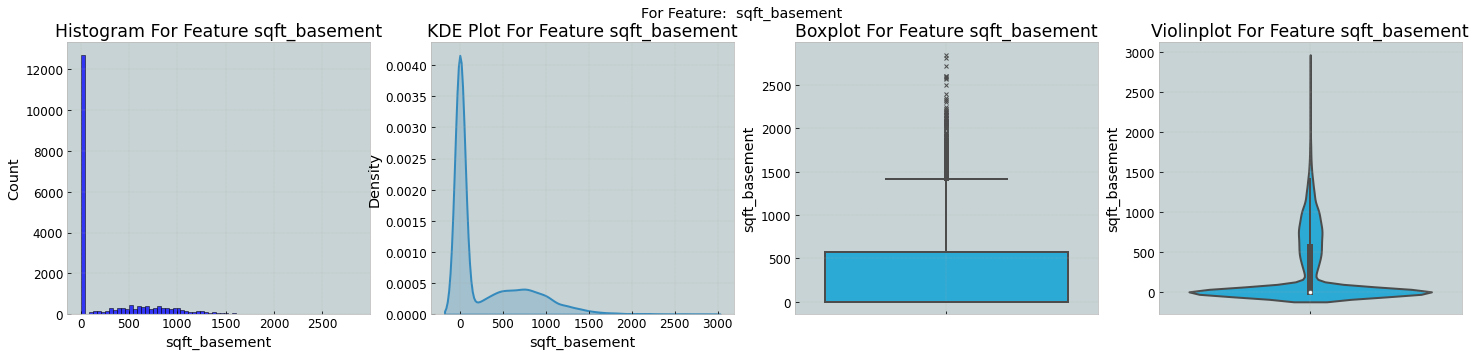

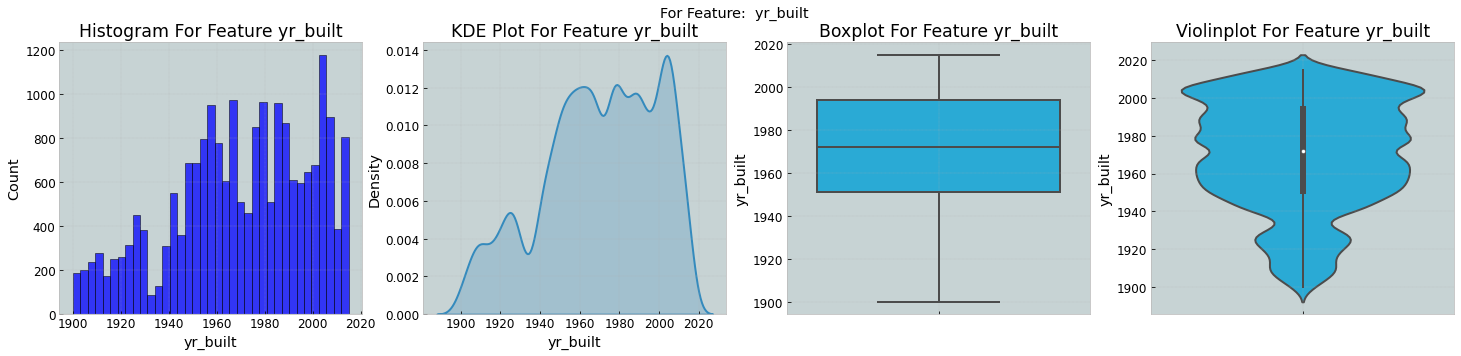

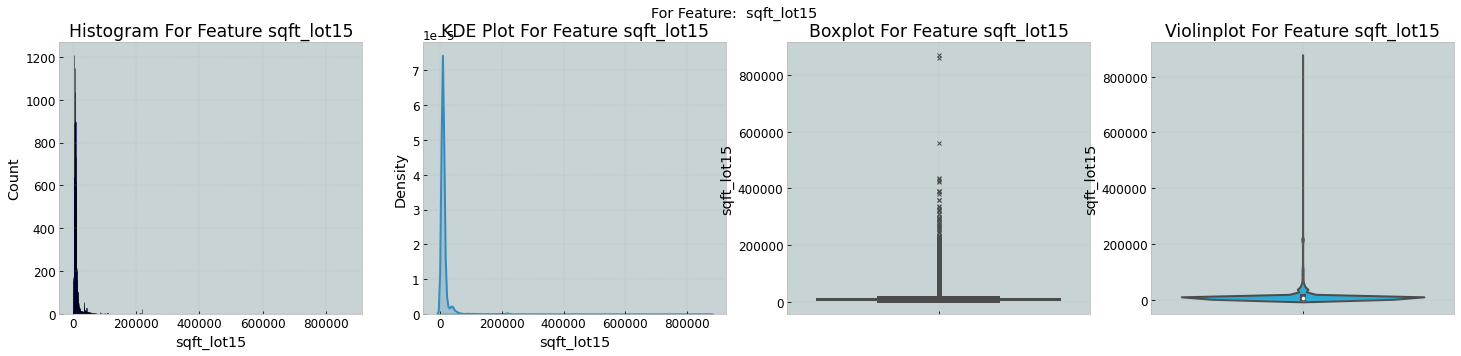

time: 39.9 s (started: 2022-07-31 13:25:53 +01:00)


In [30]:
cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','view', 'condition', 'grade','sqft_above','sqft_basement',
'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15' ]
for col in cols:
    feature_dist_clas(df4, col)

#### 4.1.3. Categorical Variable

c:\Users\Natalia\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
c:\Users\Natalia\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


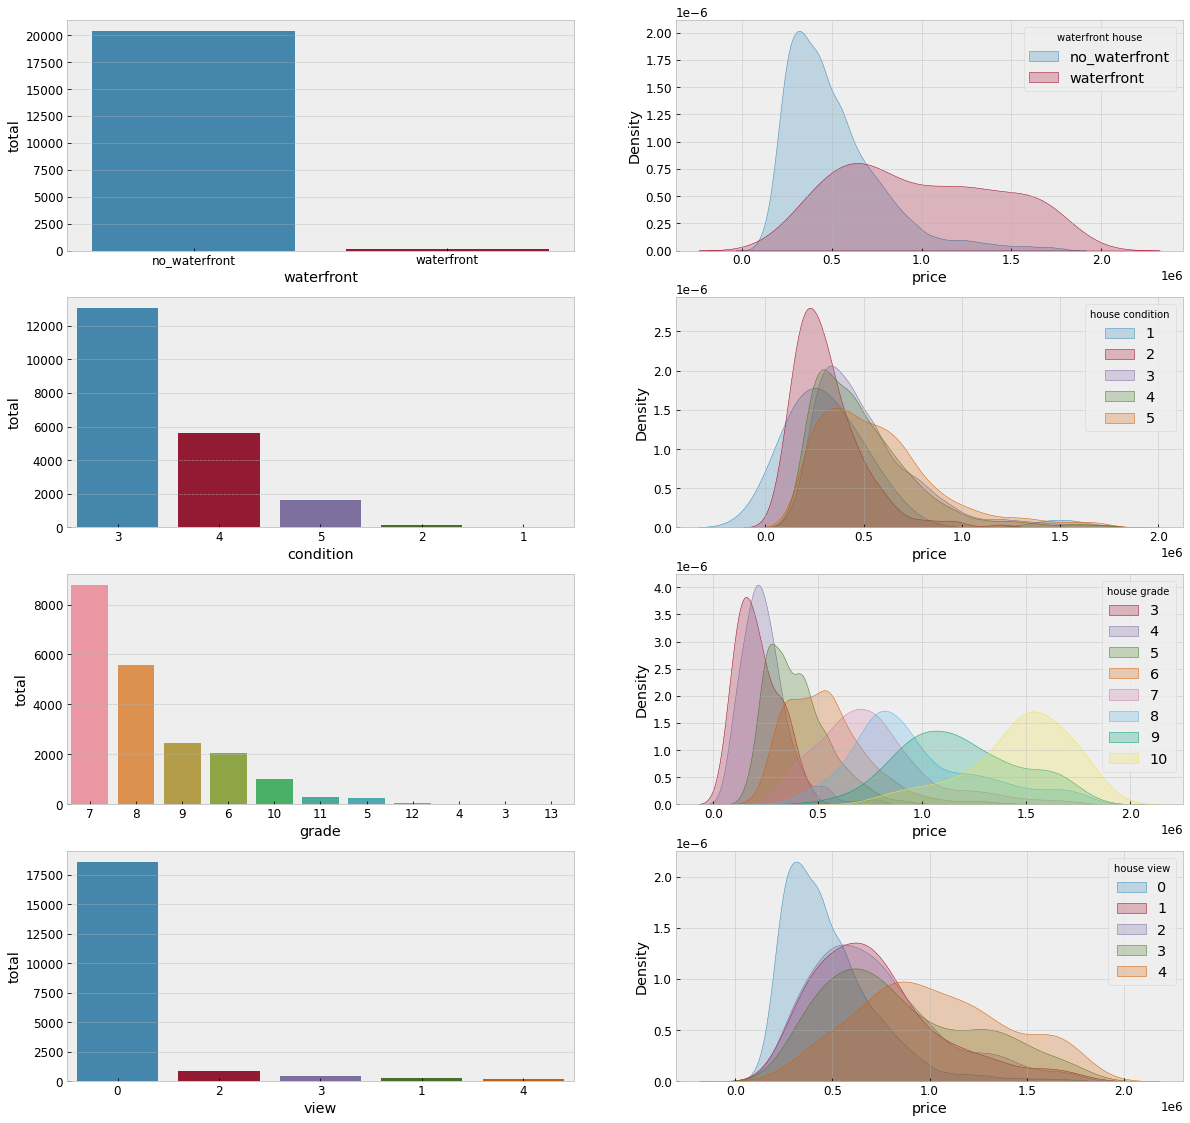

time: 3.45 s (started: 2022-07-31 13:26:33 +01:00)


In [31]:
#define dimensions of subplots (rows, columns)
fig = plt.figure(figsize=(20, 45))
gs = gridspec.GridSpec(ncols=2, nrows=9, figure=fig)

ax1 = fig.add_subplot(gs[0, 0]) # linha, coluna
ax2 = fig.add_subplot(gs[0, 1]) 
ax3 = fig.add_subplot(gs[1, 0]) 
ax4 = fig.add_subplot(gs[1, 1]) 
ax5 = fig.add_subplot(gs[2, 0]) # linha, coluna
ax6 = fig.add_subplot(gs[2, 1]) 
ax7 = fig.add_subplot(gs[3, 0]) 
ax8 = fig.add_subplot(gs[3, 1]) 

# waterfront
waterfront = pd.value_counts(df4['waterfront'], sort=True)
waterfront = pd.DataFrame(waterfront).reset_index()
waterfront.columns = ['waterfront', 'total']
waterfront['waterfront'] = waterfront['waterfront'].apply(lambda x: 'no_waterfront' if x == 0 else 'waterfront')

sns.barplot(x="waterfront", y="total", data=waterfront, ax=ax1)

sns.kdeplot(df4[df4['waterfront'] == 0]['price'], shade=True, ax=ax2)
sns.kdeplot(df4[df4['waterfront'] == 1]['price'], shade=True, ax=ax2)

ax2.legend(labels=['no_waterfront', 'waterfront' ], title = "waterfront house", 
           fontsize = 'large', title_fontsize = "10")

# condition
condition = pd.value_counts(df4['condition'], sort=True)
condition = pd.DataFrame(condition).reset_index()
condition.columns = ['condition', 'total']

sns.barplot(x="condition", y="total", data=condition, order=condition.sort_values('total', ascending=False).condition, ax=ax3)
sns.kdeplot(df4[df4['condition'] == 1]['price'], shade=True, ax=ax4)
sns.kdeplot(df4[df4['condition'] == 2]['price'], shade=True, ax=ax4)
sns.kdeplot(df4[df4['condition'] == 3]['price'], shade=True, ax=ax4)
sns.kdeplot(df4[df4['condition'] == 4]['price'], shade=True, ax=ax4)
sns.kdeplot(df4[df4['condition'] == 5]['price'], shade=True, ax=ax4)

ax4.legend(labels=['1', '2', '3', '4', '5' ], title = "house condition", 
           fontsize = 'large', title_fontsize = "10")
# grade
grade = pd.value_counts(df4['grade'], sort=True)
grade = pd.DataFrame(grade).reset_index()
grade.columns = ['grade', 'total']

sns.barplot(x="grade", y="total", data=grade, order=grade.sort_values('total', ascending=False).grade, ax=ax5)

sns.kdeplot(df4[df4['grade'] == 3]['price'], shade=True, ax=ax6)
sns.kdeplot(df4[df4['grade'] == 4]['price'], shade=True, ax=ax6)
sns.kdeplot(df4[df4['grade'] == 5]['price'], shade=True, ax=ax6)
sns.kdeplot(df4[df4['grade'] == 7]['price'], shade=True, ax=ax6)
sns.kdeplot(df4[df4['grade'] == 8]['price'], shade=True, ax=ax6)
sns.kdeplot(df4[df4['grade'] == 9]['price'], shade=True, ax=ax6)
sns.kdeplot(df4[df4['grade'] == 10]['price'], shade=True, ax=ax6)
sns.kdeplot(df4[df4['grade'] == 11]['price'], shade=True, ax=ax6)
sns.kdeplot(df4[df4['grade'] == 12]['price'], shade=True, ax=ax6)
sns.kdeplot(df4[df4['grade'] == 13]['price'], shade=True, ax=ax6)


ax6.legend(labels=['3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'], title = "house grade", 
           fontsize = 'large', title_fontsize = "10")

# view
view = pd.value_counts(df4['view'], sort=True)
view = pd.DataFrame(view).reset_index()
view.columns = ['view', 'total']

sns.barplot(x="view", y="total", data=view, order=view.sort_values('total', ascending=False).view, ax=ax7)

sns.kdeplot(df4[df4['view'] == 0]['price'], shade=True, ax=ax8)
sns.kdeplot(df4[df4['view'] == 1]['price'], shade=True, ax=ax8)
sns.kdeplot(df4[df4['view'] == 2]['price'], shade=True, ax=ax8)
sns.kdeplot(df4[df4['view'] == 3]['price'], shade=True, ax=ax8)
sns.kdeplot(df4[df4['view'] == 4]['price'], shade=True, ax=ax8)

ax8.legend(labels=['0','1', '2', '3', '4' ], title = "house view", 
           fontsize = 'large', title_fontsize = "10")

### 4.2. Bivariate Analysis

#### **H1.** Houses with more bedrooms should be more expensive.
**True** Houses with more bedrooms are more expensive

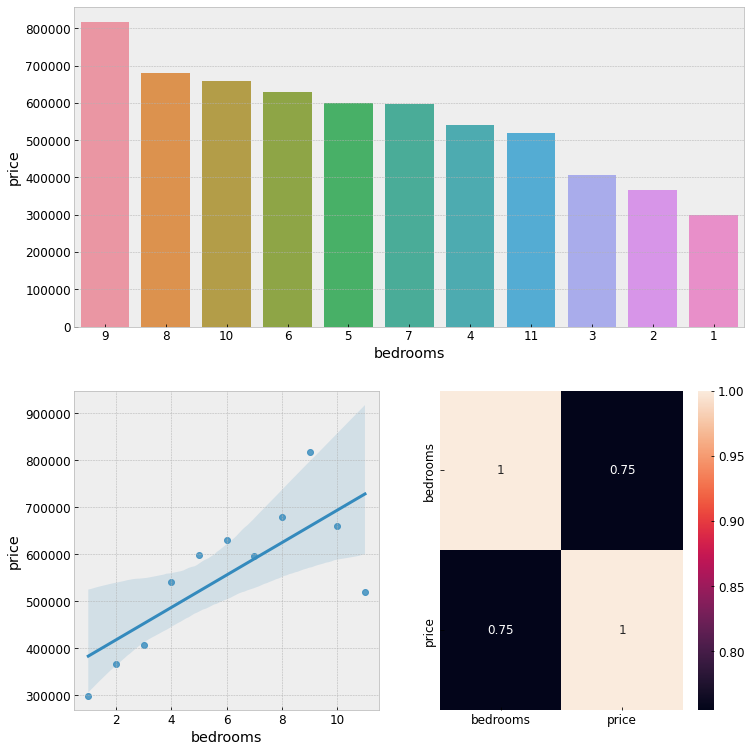

time: 1.22 s (started: 2022-07-31 13:26:37 +01:00)


In [32]:
plots(df4, 'bedrooms', 'price' )

#### **H2.** Houses with more bathrooms should be more expensive.
**True** Houses with more bathrooms are more expensive

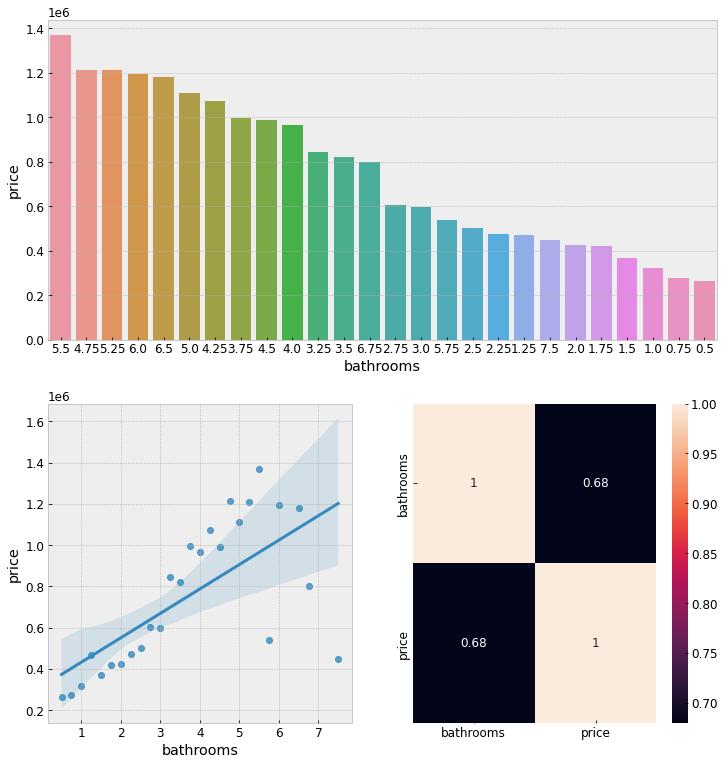

time: 1.55 s (started: 2022-07-31 13:26:38 +01:00)


In [33]:
plots(df4, 'bathrooms', 'price' )

#### **H3.** Houses with more number of floors should be more expensive.
**False** Houses with more floors are not necessarily more expensive

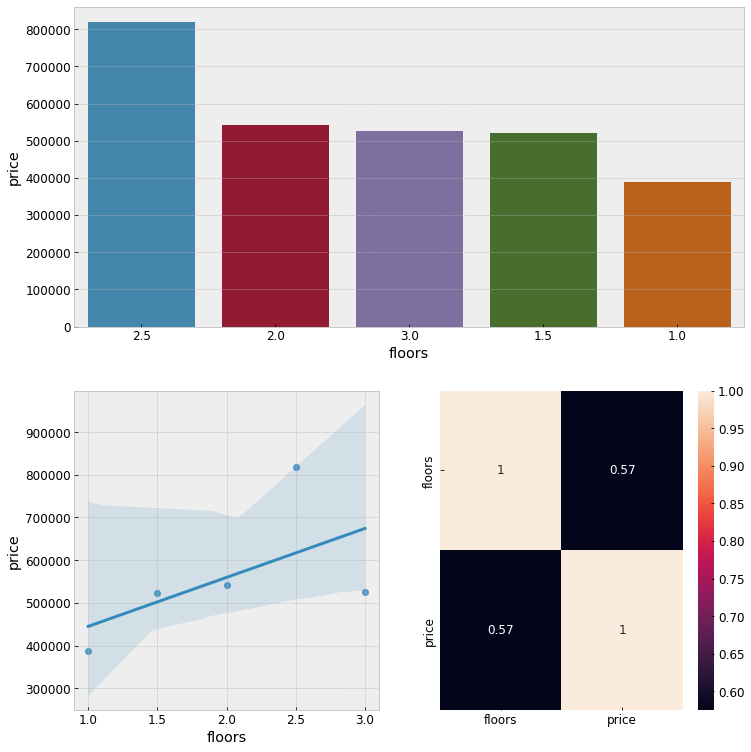

time: 1.02 s (started: 2022-07-31 13:26:40 +01:00)


In [34]:
plots(df4, 'floors', 'price' )

#### **H4.** Houses with more living area square footage should be be more expensive
**True** Houses with more living are square footage are more expensive

In [35]:
plt.figure(figsize=(12, 15))

plt.subplot(2,1,1)
sns.regplot(data=df4, x="sqft_living", y="price")

plt.subplot(2,1,2)
sns.heatmap(df4[['sqft_living', 'price']].corr(method='pearson'), annot=True)

<AxesSubplot:>

time: 2.95 s (started: 2022-07-31 13:26:41 +01:00)


#### **H5.** Houses with more lot square footage should be more expensive
**False** Houses with more lot square footage aren't necessarily more expensive

In [36]:
plt.figure(figsize=(12, 15))

plt.subplot(2,1,1)
sns.regplot(data=df4, x="sqft_lot", y="price")

plt.subplot(2,1,2)
sns.heatmap(df4[['sqft_lot', 'price']].corr(method='pearson'), annot=True)

<AxesSubplot:>

time: 3.05 s (started: 2022-07-31 13:26:44 +01:00)


#### **H6.** Houses with a basement should be more expensive
**True** Houses with a basement are more expensive. However, the basement square footage doesn't influence the price.

In [37]:
basement = df4.groupby('basement', as_index=False)['price'].median()

plt.figure(figsize=(12, 16))

plt.subplot(3,1,1)
p = sns.barplot(x="basement", y="price", order=basement.sort_values('price', ascending=False).basement, data=basement)
show_values(p)

plt.subplot(3,1,2)
sns.regplot(x='sqft_basement', y='price', data=df4)

plt.subplot(3,1,3)
sns.heatmap(df4[['sqft_basement', 'price']].corr(method='pearson'), annot=True)


<AxesSubplot:>

time: 3.16 s (started: 2022-07-31 13:26:47 +01:00)


#### **H7.** Houses with waterfront should be more expensive
**True** Houses with waterfront are more expensive

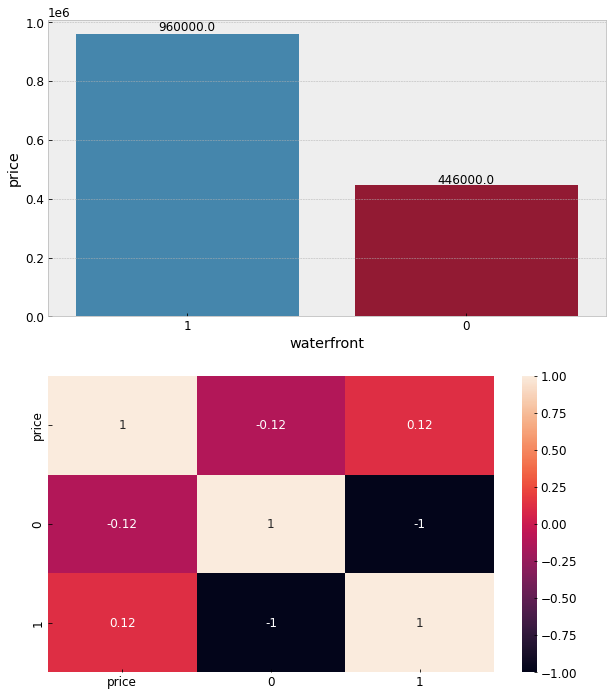

time: 547 ms (started: 2022-07-31 13:26:50 +01:00)


In [38]:
cat_plots(df4, 'waterfront', 'price')

#### **H8.** Houses with better quality of finishing and design should be more expensive.
**True** Houses with better quality of finishing are more expensive

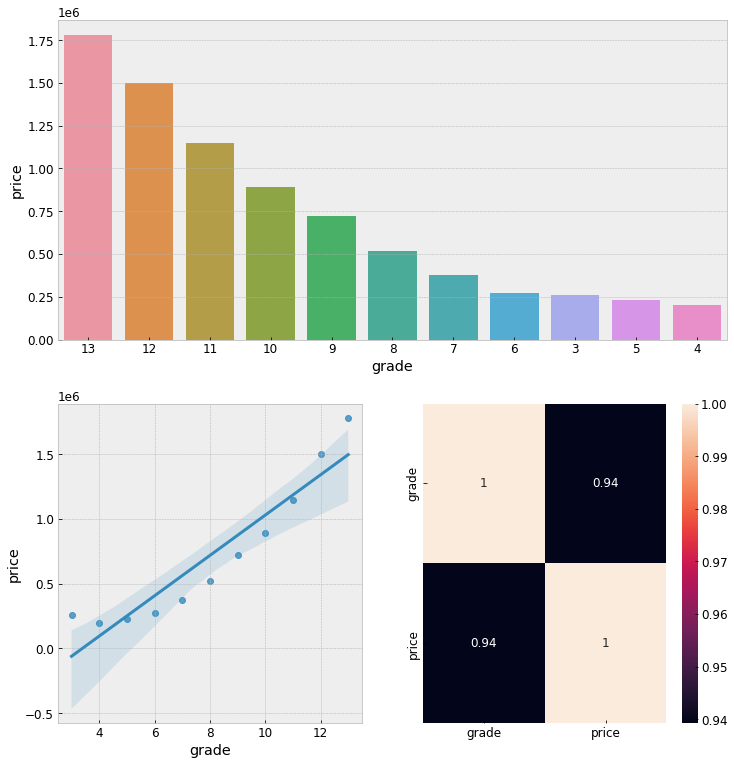

time: 1.99 s (started: 2022-07-31 13:26:51 +01:00)


In [39]:
plots(df4, 'grade', 'price' )

#### **H9.** Older houses should be cheaper
**False** The year the house was built has no strong correlation with its price

<AxesSubplot:>

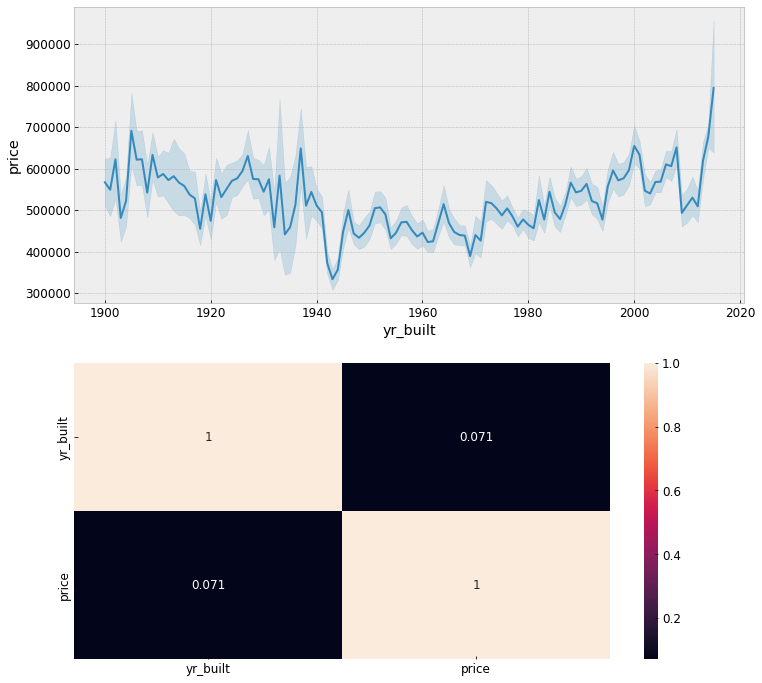

time: 5.31 s (started: 2022-07-31 13:26:53 +01:00)


In [40]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
sns.lineplot(x="yr_built", y="price", data=df4)

plt.subplot(2, 1, 2)
sns.heatmap(df4[['yr_built', 'price']].corr(method='pearson'), annot=True)

#### **H10.** Renovated houses should be more expensive
**True** Renovated houses are more expensive

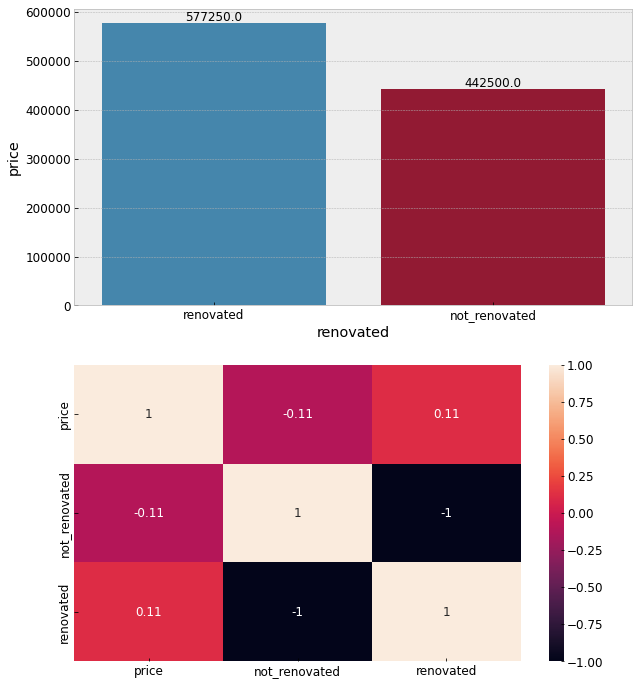

time: 546 ms (started: 2022-07-31 13:26:58 +01:00)


In [41]:
cat_plots(df4, 'renovated', 'price')

#### **H11.** Houses in better conditions should be more expensive
**True** Houses in better condition are more expensive

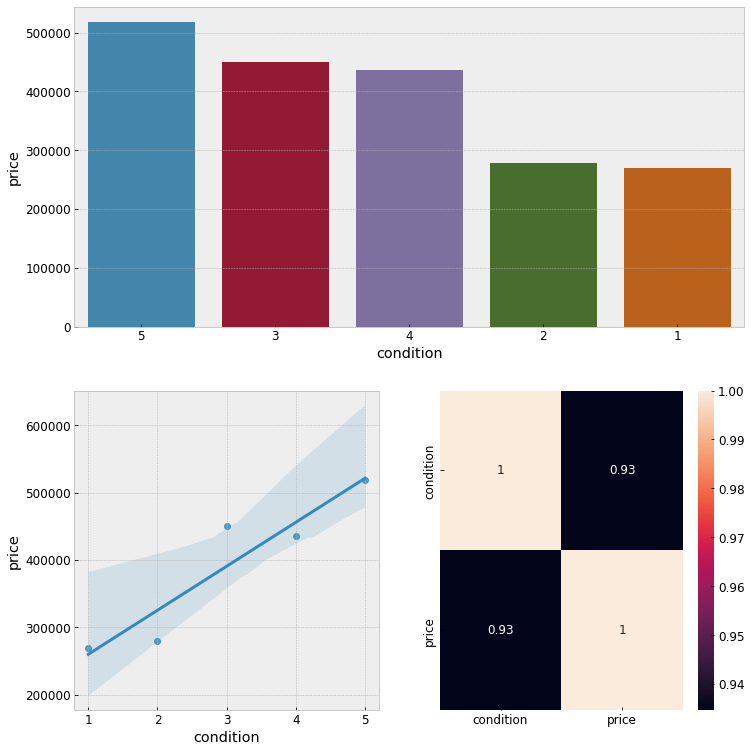

time: 968 ms (started: 2022-07-31 13:26:59 +01:00)


In [42]:
plots(df4, 'condition', 'price')

#### **H12** - The median house price increased in 5% from 2014 to 2015
**False** The median house price increase was 0.05%

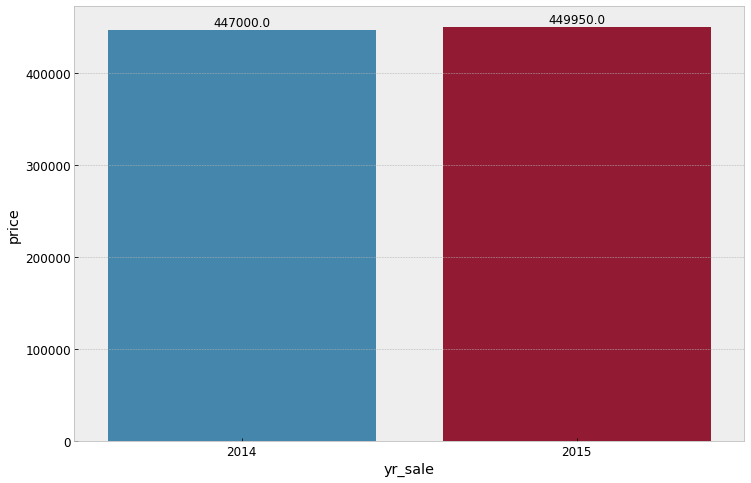

time: 313 ms (started: 2022-07-31 13:27:00 +01:00)


In [43]:
YoY = df4.groupby('yr_sale', as_index=False)['price'].median()
p = sns.barplot(x='yr_sale', y='price', data=YoY)
show_values(p)

In [44]:
diff = YoY['yr_sale'][1] - YoY['yr_sale'][0]
percent = diff/YoY['yr_sale'][0]*100
print(f'Percentage Increase {percent:.2f}%')

Percentage Increase 0.05%
time: 0 ns (started: 2022-07-31 13:27:00 +01:00)


#### **H13** - The median monthly increase in house prices is 5%
** False** The median montly increase in house price is less than 5%

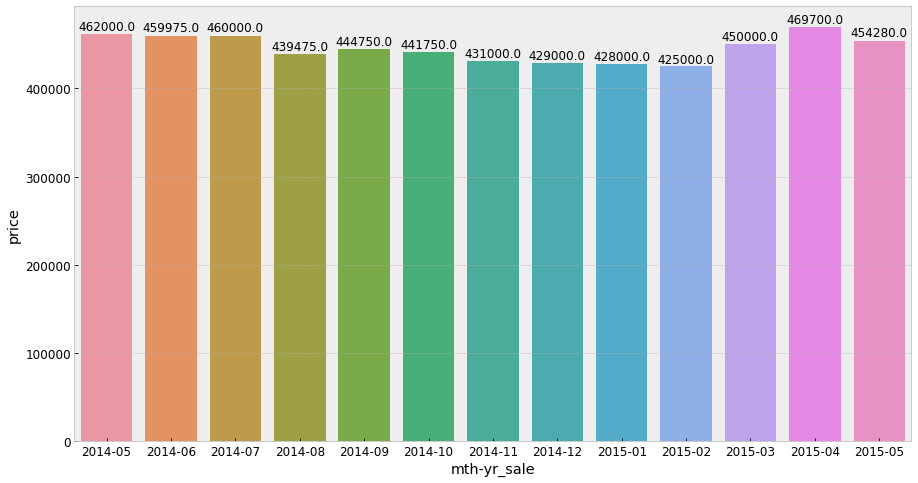

time: 406 ms (started: 2022-07-31 13:27:00 +01:00)


In [45]:
MoM = df4.groupby('mth-yr_sale', as_index=False)['price'].median()

plt.figure(figsize=(15, 8))
p = sns.barplot(x='mth-yr_sale', y='price', data=MoM)
show_values(p)

In [46]:
MoM['pct_change'] = MoM['price'].pct_change()
MoM

mth-yr_sale     price  pct_change
0      2014-05 462000.00         NaN
1      2014-06 459975.00       -0.00
2      2014-07 460000.00        0.00
3      2014-08 439475.00       -0.04
4      2014-09 444750.00        0.01
5      2014-10 441750.00       -0.01
6      2014-11 431000.00       -0.02
7      2014-12 429000.00       -0.00
8      2015-01 428000.00       -0.00
9      2015-02 425000.00       -0.01
10     2015-03 450000.00        0.06
11     2015-04 469700.00        0.04
12     2015-05 454280.00       -0.03

time: 16 ms (started: 2022-07-31 13:27:01 +01:00)


#### **H14.** House prices drop 10% during winter
**False** House prices drop 8% during winter

In [47]:
cat_plots(df4, 'season_of_sale', 'price')

time: 859 ms (started: 2022-07-31 13:27:01 +01:00)


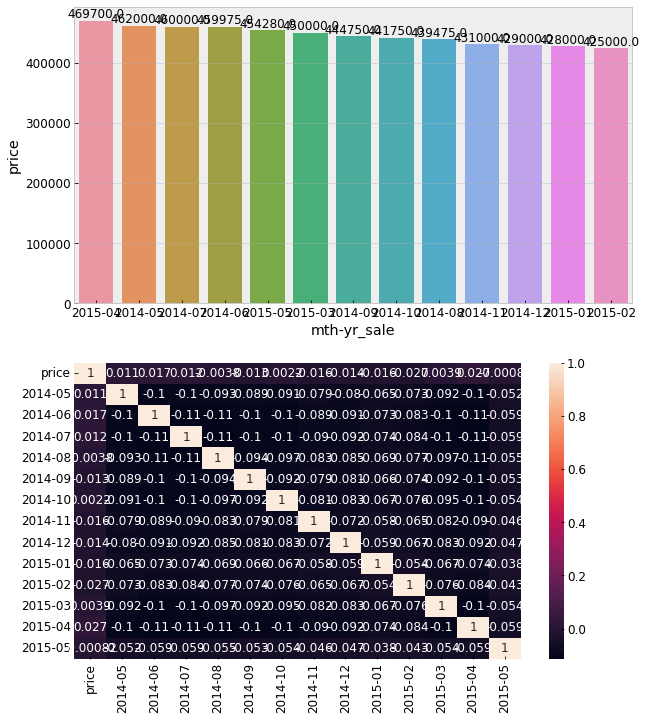

time: 2.27 s (started: 2022-07-31 13:27:02 +01:00)


In [48]:
cat_plots(df4, 'mth-yr_sale', 'price')

In [49]:
season_of_sale = df4.groupby('season_of_sale', as_index=False)['price'].median()
diff = season_of_sale['price'][1] - season_of_sale['price'][4]
percent = diff/season_of_sale['price'][4]*100
print(f'Price percentage difference {percent:.2f}%')

Price percentage difference 8.71%
time: 16 ms (started: 2022-07-31 13:27:04 +01:00)


#### **H15.** House prices varies depending on the location
**True** Median House Prices can vary 500% within the same county

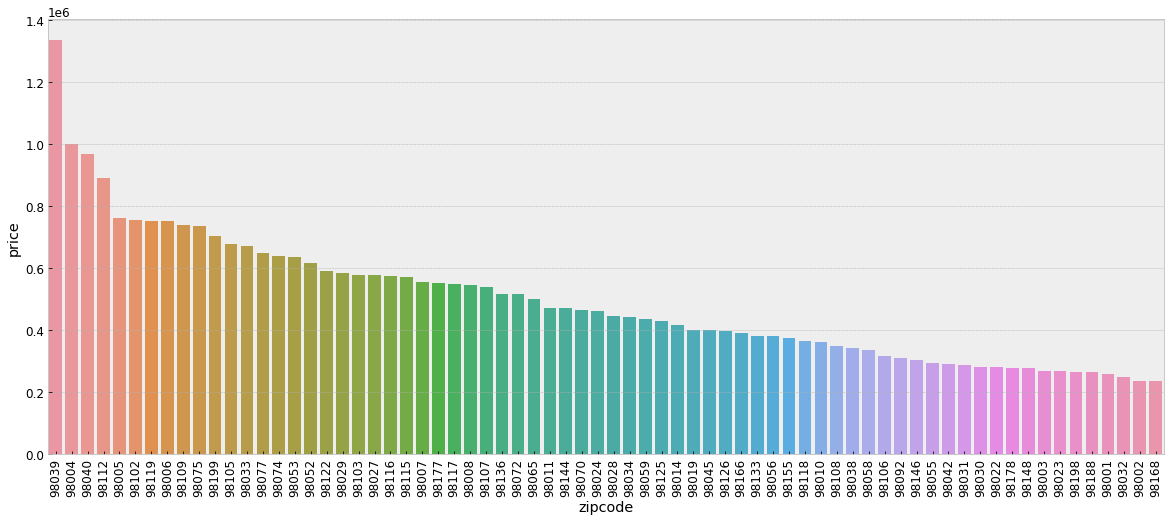

time: 1.94 s (started: 2022-07-31 13:27:04 +01:00)


In [50]:
zipcode = df4.groupby('zipcode', as_index=False)['price'].median()

plt.figure(figsize=(20, 8))

p = sns.barplot(x='zipcode', y='price', order=zipcode.sort_values('price', ascending=False).zipcode , data=zipcode )
plt.xticks(rotation=90 );

In [51]:
zipcode.sort_values('price', ascending=False)

zipcode      price
24   98039 1335000.00
3    98004  999974.50
25   98040  968000.00
48   98112  890500.00
4    98005  760000.00
41   98102  753500.00
53   98119  750000.00
5    98006  750000.00
47   98109  740000.00
38   98075  735000.00
69   98199  704500.00
43   98105  679000.00
21   98033  670000.00
39   98077  649975.00
37   98074  640000.00
29   98053  633950.00
28   98052  615000.00
54   98122  589500.00
17   98029  582500.00
42   98103  578888.00
15   98027  577500.00
50   98116  575000.00
49   98115  570000.00
6    98007  555000.00
65   98177  550500.00
51   98117  549925.00
7    98008  544950.00
45   98107  538250.00
58   98136  517500.00
36   98072  515000.00
34   98065  500000.00
9    98011  470000.00
59   98144  470000.00
35   98070  465000.00
14   98024  460000.00
16   98028  445500.00
22   98034  443000.00
33   98059  435000.00
55   98125  429950.00
10   98014  415000.00
11   98019  401250.00
27   98045  399500.00
56   98126  396500.00
63   98166  389999.50
57   98133  379975.00
31   98056  379800.00
62   98155  375000.00
52   98118  366000.00
8    98010  359999.50
46   98108  349950.00
23   98038  342000.00
32   98058  335000.00
44   98106  315000.00
40   98092  309780.00
60   98146  305000.00
30   98055  294950.00
26   98042  292000.00
19   98031  288000.00
18   98030  282255.00
12   98022  280000.00
66   98178  278277.00
61   98148  278000.00
2    98003  268475.00
13   98023  268450.00
68   98198  265000.00
67   98188  264000.00
0    98001  260000.00
20   98032  249000.00
1    98002  235000.00
64   98168  235000.00

time: 15 ms (started: 2022-07-31 13:27:06 +01:00)


### 4.3. Multivariate Analysis

#### 4.3.1. Numerical Attributes

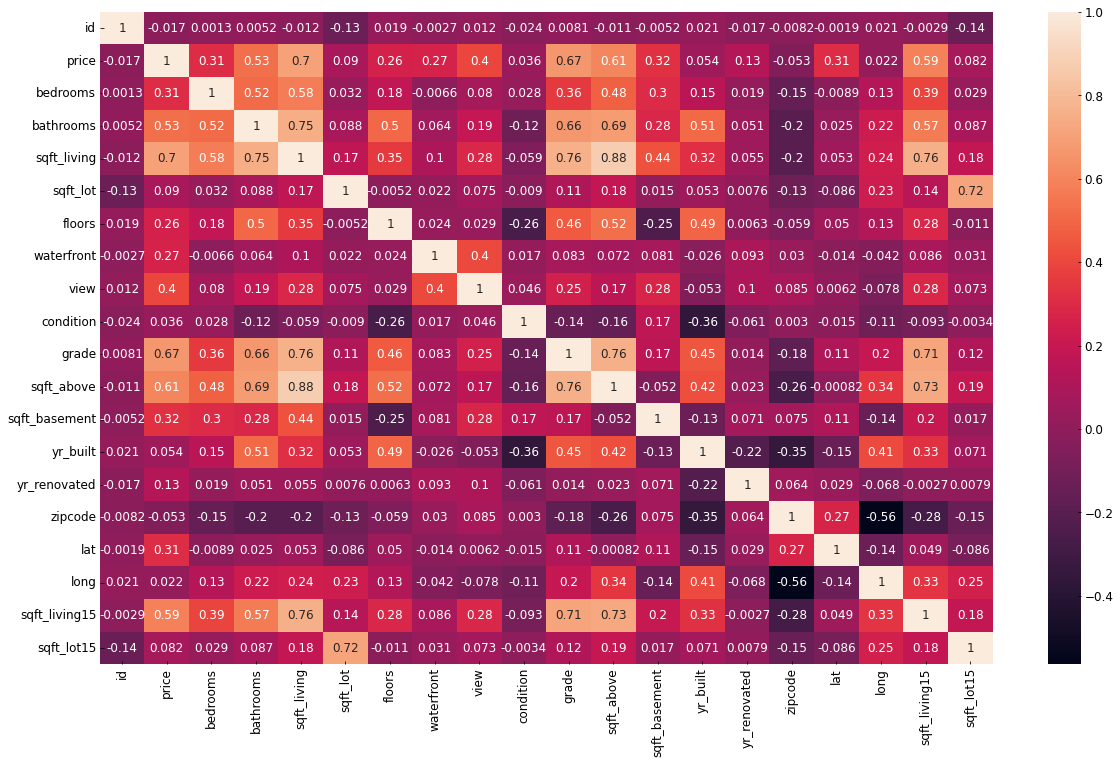

time: 3.17 s (started: 2022-07-31 13:27:06 +01:00)


In [52]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20, 12))
sns.heatmap(correlation, annot=True);

# 5.0. Step 5 - Data Preparation

In [53]:
df5 = df4.copy()

time: 16 ms (started: 2022-07-31 13:27:09 +01:00)


## 5.1. Transformation

### 5.1.1 Responsible Variable Transformation

In [54]:
df5['price'] = np.log1p(df5['price'])

time: 0 ns (started: 2022-07-31 13:27:09 +01:00)


### 5.1.2 Nature Transformation

In [55]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.* np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.* np.pi/12)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.* np.pi/12)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.* np.pi/12)))


time: 203 ms (started: 2022-07-31 13:27:09 +01:00)


### 5.1.3 Encoding season of sale

In [ ]:
# season of sale 
df5 = pd.get_dummies(df5, prefix=['season_of_sale'], columns=['season_of_sale'])

## 5.2. Splitting dataframe into training and test dataset

In [56]:
# df6 = df6.sort_values(by='date').reset_index()
min_date = df5['date'].min()
max_date = df5['date'].max()
start_of_test_set = df5['date'].max() - datetime.timedelta(days=10*7)
print(f'min date: {min_date}\nmax date: {max_date}\nstart_of_test_set: {start_of_test_set}')

min date: 2014-05-02 00:00:00
max date: 2015-05-27 00:00:00
start_of_test_set: 2015-03-18 00:00:00
time: 16 ms (started: 2022-07-31 13:27:10 +01:00)


In [57]:
# training 
X_train = df5[df5['date'] < '2015-03-18']
y_train = X_train['price']

# test set
X_test = df5[df5['date'] >= '2015-03-18']  
y_test = X_test['price']

a = len(X_train)/len(df5)*100

print(f'Training Min Date: {X_train["date"].min()}, size: {len(X_train)/len(df5)*100:.2f}%')
print(f'Training Max Date: {X_train["date"].max()}')

print(f'Test Min Date: {X_test["date"].min()}, size: {len(X_test)/len(df5)*100:.2f}%')
print(f'Test Max Date: {X_test["date"].max()}')

Training Min Date: 2014-05-02 00:00:00, size: 82.29%
Training Max Date: 2015-03-17 00:00:00
Test Min Date: 2015-03-18 00:00:00, size: 17.71%
Test Max Date: 2015-05-27 00:00:00
time: 31 ms (started: 2022-07-31 13:27:10 +01:00)


## 5.3. Rescaling

In [58]:
rs = RobustScaler()
mms = MinMaxScaler()

# robust scaler 
var_rs = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 
'sqft_above', 'sqft_basement', 'yr_sale', 'sqft_living15', 'sqft_lot15']
X_train[var_rs]= rs.fit_transform(X_train[var_rs].values)
pickle.dump(rs,open("C:/Users/Natalia/Desktop/house_rocket/parameter/rs_rescaling.pkl", "wb"))
X_test[var_rs]= rs.transform(X_test[var_rs].values)


# min-max scaler
var_mms = ['yr_built', 'yr_renovated']
X_train[var_mms]= mms.fit_transform(X_train[var_mms].values)
pickle.dump(mms, open("C:/Users/Natalia/Desktop/house_rocket/parameter/mms_rescaling.pkl", "wb"))
X_test[var_mms]= mms.transform(X_test[var_mms].values)


time: 78 ms (started: 2022-07-31 13:27:10 +01:00)


c:\Users\Natalia\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
c:\Users\Natalia\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
c:\Users\Natalia\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

## 5.4. Encoding

In [59]:
# zipcode
tgt = TargetEncoder()
X_train['zipcode'] = tgt.fit_transform(X_train['zipcode'], X_train['price'])
pickle.dump(tgt, open("C:/Users/Natalia/Desktop/house_rocket/parameter/zipcode_encoded.pkl", "wb"))

X_test['zipcode'] = tgt.transform(X_test['zipcode'], X_test['price'])


c:\Users\Natalia\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
c:\Users\Natalia\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


time: 265 ms (started: 2022-07-31 13:27:10 +01:00)


C:\Users\Natalia\AppData\Local\Temp/ipykernel_12900/1365298346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['zipcode'] = tgt.fit_transform(X_train['zipcode'], X_train['price'])
C:\Users\Natalia\AppData\Local\Temp/ipykernel_12900/1365298346.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['zipcode'] = tgt.transform(X_test['zipcode'], X_test['price'])


# 6.0. Feature Selection

## 6.2. Boruta as Feature Selector

In [60]:
# training and test dataset for Boruta
X_train = X_train.drop(['month', 'week_of_year', 'basement', 'renovated', 'mth-yr_sale'], axis=1)
X_train_n = X_train.drop(['date', 'price', 'id'], axis=1).values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)
selected_cols = boruta.support_.tolist()

# best features 
X_train_fs = X_train.drop(['date', 'price', 'id'], axis=1)

cols_selected_boruta = X_train_fs.iloc[:, selected_cols].columns.tolist()

# not selected boruta
cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

# columns to add
feat_to_add = ['date', 'price'] 

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)



Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	17


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	17
time: 1min 47s (started: 2022-07-31 13:27:10 +01:00)


In [61]:
cols_selected_boruta

['sqft_living',
 'sqft_lot',
 'view',
 'grade',
 'sqft_above',
 'yr_built',
 'zipcode',
 'sqft_living15',
 'sqft_lot15']

time: 0 ns (started: 2022-07-31 13:28:58 +01:00)


# 7.0. Machine Learning Modeling

In [62]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time series Data Preparation
x_training = X_train[cols_selected_boruta_full]
x_training['price'] = np.log1p(x_training['price'])

time: 16 ms (started: 2022-07-31 13:28:58 +01:00)


C:\Users\Natalia\AppData\Local\Temp/ipykernel_12900/3908916392.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_training['price'] = np.log1p(x_training['price'])


In [63]:
x_training.head()

sqft_living  sqft_lot  view  grade  sqft_above  yr_built  zipcode  sqft_living15  sqft_lot15       date  price
0        -0.68     -0.39  0.00   0.00       -0.39      0.48    12.54          -0.59       -0.43 2014-10-13   2.59
1         0.57     -0.09  0.00   0.00        0.59      0.44    13.00          -0.18       -0.01 2014-12-09   2.65
2        -1.05      0.41  0.00  -1.00       -0.79      0.29    12.99           1.00        0.08 2015-02-25   2.57
3         0.02     -0.50  0.00   0.00       -0.51      0.57    13.13          -0.56       -0.56 2014-12-09   2.66
4        -0.23      0.06  0.00   1.00        0.11      0.76    13.36          -0.06       -0.04 2015-02-18   2.65

time: 15 ms (started: 2022-07-31 13:28:58 +01:00)


## 7.1. Average Model

In [64]:
aux1 = x_test.copy()
aux1['price'] = y_test.copy()
aux1['zipcode2'] = df5['zipcode'].copy()

# prediction
aux2 = aux1.groupby('zipcode2', as_index=False)['price'].mean().rename(columns={'price': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='zipcode2')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))

baseline_result

Model Name       MAE  MAPE      RMSE
0  Average Model 132290.53  0.26 196756.29

time: 31 ms (started: 2022-07-31 13:28:58 +01:00)


## 7.2. Linear Regression Model

In [65]:
# model 
lr = LinearRegression().fit(x_train, y_train)

# prediction
y_hat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(y_hat_lr))

lr_result

Model Name      MAE  MAPE      RMSE
0  Linear Regression 90413.97  0.17 137175.43

time: 63 ms (started: 2022-07-31 13:28:58 +01:00)


### 7.2.1 Linear Regression Model - Cross Validation

In [66]:
x_training.head()

sqft_living  sqft_lot  view  grade  sqft_above  yr_built  zipcode  sqft_living15  sqft_lot15       date  price
0        -0.68     -0.39  0.00   0.00       -0.39      0.48    12.54          -0.59       -0.43 2014-10-13   2.59
1         0.57     -0.09  0.00   0.00        0.59      0.44    13.00          -0.18       -0.01 2014-12-09   2.65
2        -1.05      0.41  0.00  -1.00       -0.79      0.29    12.99           1.00        0.08 2015-02-25   2.57
3         0.02     -0.50  0.00   0.00       -0.51      0.57    13.13          -0.56       -0.56 2014-12-09   2.66
4        -0.23      0.06  0.00   1.00        0.11      0.76    13.36          -0.06       -0.04 2015-02-18   2.65

time: 16 ms (started: 2022-07-31 13:28:58 +01:00)


In [67]:
lr_result_cv = cross_validation(x_training , 5, 'Linear Regression', lr, verbose=False)

time: 141 ms (started: 2022-07-31 13:28:58 +01:00)


## 7.3. Linear Regression Regularized Model

In [68]:
# model
lrr = Lasso(0.01).fit(x_train, y_train)

# prediction
y_hat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression Regularized', np.expm1(y_test), np.expm1(y_hat_lrr))

lrr_result

Model Name      MAE  MAPE      RMSE
0  Linear Regression Regularized 92149.52  0.17 139984.41

time: 47 ms (started: 2022-07-31 13:28:58 +01:00)


### 7.3.1 Linear Regression Regularized Model - Cross Validation

In [69]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Regularized', lrr, verbose=False)

time: 125 ms (started: 2022-07-31 13:28:58 +01:00)


## 7.4. Random Forest Regressor

In [70]:
# model 
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
y_hat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(y_hat_rf))

rf_result

Model Name      MAE  MAPE      RMSE
0  Random Forest Regressor 76029.38  0.14 116213.30

time: 5.76 s (started: 2022-07-31 13:28:59 +01:00)


### 7.4.1. Random Forest Regressor - Cross Validation

In [71]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
time: 18.9 s (started: 2022-07-31 13:29:04 +01:00)


## 7.5. XGBoost Regressor

In [72]:
# model 
xgb = XGBRegressor(objective='reg:squarederror',
              n_estimators=100,
              eta=0.001,
              subsample=0.7,
              colsample_bytree=0.9).fit(x_train, y_train)
# prediction
y_hat_xgb = xgb.predict(x_test)

#performance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(y_hat_xgb))
xgb_result = ml_error('XGBoost Regressor', y_test, y_hat_xgb)
xgb_result

Model Name   MAE  MAPE  RMSE
0  XGBoost Regressor 11.37  0.87 11.38

time: 2.03 s (started: 2022-07-31 13:29:23 +01:00)


### 7.5.1 XGBoost Regressor

In [73]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', xgb, verbose=True)


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
time: 3.52 s (started: 2022-07-31 13:29:26 +01:00)


## 7.6. Comparing Model performances

### 7.6.1 Single Performance

In [74]:
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

Model Name       MAE  MAPE      RMSE
0              XGBoost Regressor     11.37  0.87     11.38
0        Random Forest Regressor  76029.38  0.14 116213.30
0              Linear Regression  90413.97  0.17 137175.43
0  Linear Regression Regularized  92149.52  0.17 139984.41
0                  Average Model 132290.53  0.26 196756.29

time: 16 ms (started: 2022-07-31 13:29:29 +01:00)


### 7.6.2 Real Performance - Cross Validation

In [75]:
modeling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modeling_result_cv

Model Name          MAE CV       MAPE CV         RMSE CV
0              Linear Regression   0.16 +/- 0.01  0.01 +/- 0.0   0.21 +/- 0.01
0  Linear Regression Regularized   0.31 +/- 0.01  0.02 +/- 0.0   0.39 +/- 0.01
0        Random Forest Regressor   0.14 +/- 0.01  0.01 +/- 0.0   0.19 +/- 0.01
0              XGBoost Regressor  11.98 +/- 0.01  0.92 +/- 0.0  11.99 +/- 0.01

time: 15 ms (started: 2022-07-31 13:29:29 +01:00)


# 8.0. Hyperparameter Fine Tuning

## 8.1. Random Search

In [76]:
# param = {'bootstrap': [True, False],
#         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#         'max_features': ['auto', 'sqrt'],
#         'min_samples_leaf': [1, 2, 4, 10, 15, 20],
#         'min_samples_split': [2, 5, 10, 12, 15, 20],
#         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# MAX_EVAL = 10

time: 0 ns (started: 2022-07-31 13:29:29 +01:00)


In [77]:
# import random

time: 0 ns (started: 2022-07-31 13:29:29 +01:00)


In [78]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     #choose values for parameters randomly
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)

#     # model
#     rf = RandomForestRegressor(bootstrap= hp['bootstrap'],
#                                max_depth= hp['max_depth'],
#                                max_features= hp['max_features'],
#                                min_samples_leaf= hp['min_samples_leaf'],
#                                min_samples_split= hp['min_samples_split'],
#                                n_estimators= hp['n_estimators'],
#                                n_jobs=-1, random_state=42)
    
#     # performance
#     result = cross_validation(x_training, 5, ' Random Forest Regressor', rf, verbose=False)
#     final_result = pd.concat([final_result, result])


# final_result

time: 16 ms (started: 2022-07-31 13:29:29 +01:00)


## 8.2. Final Model

In [79]:
param_tuned = {'bootstrap': False,
        'max_depth': 60,
        'max_features': 'sqrt',
        'min_samples_leaf': 2,
        'min_samples_split': 10,
        'n_estimators': 1000}

time: 0 ns (started: 2022-07-31 13:29:29 +01:00)


In [80]:
# model
rf_tuned = RandomForestRegressor(bootstrap= param_tuned['bootstrap'],
                               max_depth= param_tuned['max_depth'],
                               max_features= param_tuned['max_features'],
                               min_samples_leaf= param_tuned['min_samples_leaf'],
                               min_samples_split= param_tuned['min_samples_split'],
                               n_estimators= param_tuned['n_estimators']).fit(x_train, y_train)

# prediction
y_hat_rf_tuned = rf_tuned.predict(x_test)
    
# performance
rf_result_tuned = ml_error(' Random Forest Regressor', np.expm1(y_test), np.expm1(y_hat_rf_tuned))
rf_result_tuned

Model Name      MAE  MAPE      RMSE
0   Random Forest Regressor 75345.07  0.14 115440.40

time: 1min 13s (started: 2022-07-31 13:29:29 +01:00)


In [81]:
y_testmax = np.expm1(y_test).max()
y_testmin = np.expm1(y_test).min()

y_test_range = y_testmax - y_testmin
y_testmean = np.expm1(y_test).mean()
print(f'y_test range: {y_test_range}\ny test mean: {y_testmean}')

y_test range: 1721749.9999999993
y test mean: 527932.9342503438
time: 16 ms (started: 2022-07-31 13:30:43 +01:00)


# 9.0. Error interpretation

In [182]:
df9 = X_test[cols_selected_boruta_full]

# # rescale
# df9['price'] = np.expm1(df9['price'])
df9['predictions'] = np.expm1(y_hat_rf_tuned)
df9['zipcode'] = np.expm1(df9['zipcode'])
# insert column id
df9['id'] = X_test['id']
df9['id'] = df9['id'].apply(lambda x: int(x))
df9 = df9.drop(columns=['sqft_living', 'sqft_lot', 'view', 'grade', 'sqft_above', 'yr_built',
       'sqft_living15', 'sqft_lot15', 'date', 'price'], axis=1)

time: 31 ms (started: 2022-07-31 18:15:22 +01:00)


C:\Users\Natalia\AppData\Local\Temp/ipykernel_12900/3321291423.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Natalia\AppData\Local\Temp/ipykernel_12900/3321291423.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Natalia\AppData\Local\Temp/ipykernel_12900/3321291423.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

## 9.1. Business Performance

In [183]:
aux = df1
aux['id'] = aux['id'].drop_duplicates()
df9 = pd.merge(df9, aux, how='inner', on='id')
df9 = df9.rename(columns={'zipcode_y': 'zipcode', 'zipcode_x': 'avg_price_zip'})
df9 = df9[['id', 'date', 'yr_built', 'yr_renovated', 'zipcode', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 
           'sqft_basement', 'sqft_living15', 'sqft_lot15', 'floors','waterfront', 'view', 'condition', 'grade', 'lat', 'long', 
           'avg_price_zip', 'price', 'predictions']]


time: 328 ms (started: 2022-07-31 18:15:22 +01:00)


In [184]:
df9['to_buy'] = df9.apply(lambda x: 'good_deal' if x['price'] <= x['predictions']  else "bad_deal", axis=1 )

time: 219 ms (started: 2022-07-31 18:15:23 +01:00)


In [185]:
good_deals = df9[df9['to_buy'] == 'good_deal']

time: 15 ms (started: 2022-07-31 18:15:23 +01:00)


In [186]:
# df91 = good_deals.groupby(['id', 'zipcode', 'price', 'lat', 'long'], as_index=False)['predictions'].sum()
df91 = good_deals

df9_aux1 = good_deals[['id', 'zipcode', 'price', 'predictions', 'lat', 'long']].groupby('zipcode', as_index=False).apply(lambda x: mean_absolute_error(x['price'], x['predictions']))
df9_aux1 = pd.DataFrame(df9_aux1)
df9_aux1.columns = ['zipcode', 'MAE']

df9_aux2 = good_deals[['id', 'zipcode', 'price', 'predictions', 'lat', 'long']].groupby('zipcode', as_index=False).apply(lambda x: mean_absolute_percentage_error(x['price'], x['predictions']))
df9_aux2 = pd.DataFrame(df9_aux2)
df9_aux2.columns = ['zipcode', 'MAPE']

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='zipcode')
df92 = pd.merge(df91, df9_aux3, how='inner', on='zipcode')

#scenarios 
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']
df92['id'] = df92['id'].apply(lambda x: int(x)) 
df93 = df92[['id', 'zipcode', 'price', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


time: 375 ms (started: 2022-07-31 18:15:23 +01:00)


In [187]:
df93 = df92[df92['price'] < df92['worst_scenario']]

time: 0 ns (started: 2022-07-31 18:15:24 +01:00)


In [188]:
df93['profit_worst_scn'] = df93['worst_scenario'] - df93['price']
df93['profit_best_scn'] = df93['best_scenario'] - df93['price']

time: 0 ns (started: 2022-07-31 18:15:24 +01:00)


C:\Users\Natalia\AppData\Local\Temp/ipykernel_12900/4238103329.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Natalia\AppData\Local\Temp/ipykernel_12900/4238103329.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [189]:
df93 = df93[df93['MAPE'] < 0.15].reset_index(drop=True)

time: 15 ms (started: 2022-07-31 18:15:25 +01:00)


In [190]:
good_deals_final = df93
good_deals_final.set_index('id')
good_deals_final.head()

id       date  yr_built  yr_renovated  zipcode  bedrooms  bathrooms  sqft_living  sqft_lot  sqft_above  sqft_basement  sqft_living15  sqft_lot15  floors  waterfront  view  condition  grade   lat    long  avg_price_zip     price  predictions     to_buy      MAE  MAPE  worst_scenario  best_scenario  profit_worst_scn  profit_best_scn
0  8651430370 2015-04-25      1969             0    98042         3       1.00         1240      5200        1240              0            870        5200    1.00           0     0          3      6 47.37 -122.08      292301.74 150000.00    183737.20  good_deal 25001.47  0.11       158735.73      208738.67           8735.73         58738.67
1  3422059085 2015-03-24      1953             0    98042         2       1.00          900     23000         900              0           1460        8265    1.00           0     0          2      7 47.36 -122.16      292301.74 157340.00    206684.90  good_deal 25001.47  0.11       181683.43      231686.37          24343.43         74346.37
2  2799800750 2015-04-16      2003             0    98042         4       2.50         2500      4750        2500              0           2690        4750    2.00           0     0          3      8 47.37 -122.12      292301.74 300000.00    327521.53  good_deal 25001.47  0.11       302520.06      352523.01           2520.06         52523.01
3  3211580210 2015-04-11      1988             0    98042         3       1.75         1730      9893        1730              0           2120        9108    1.00           0     0          4      9 47.37 -122.16      292301.74 299900.00    332475.55  good_deal 25001.47  0.11       307474.08      357477.03           7574.08         57577.03
4  5466310060 2015-03-24      1983             0    98042         2       1.50         1230      1561        1230              0           1660        2243    2.00           0     0          3      7 47.38 -122.15      292301.74 139500.00    211188.03  good_deal 25001.47  0.11       186186.56      236189.50          46686.56         96689.50

time: 78 ms (started: 2022-07-31 18:15:25 +01:00)


In [191]:
os.makedirs("C:/Users/Natalia/Documents/house_rocket", exist_ok=True)  
good_deals_final.to_csv('C:/Users/Natalia/Documents/house_rocket/good_deals.csv')  

time: 110 ms (started: 2022-07-31 18:15:25 +01:00)


In [ ]:
df93 = df93[['id', 'zipcode', 'price', 'predictions', 'worst_scenario', 'best_scenario', 'profit_worst_scn', 'profit_best_scn', 'MAE', 'MAPE']]
df93.sort_values('MAPE', ascending=False).head()

id  zipcode     price  predictions  worst_scenario  best_scenario  profit_worst_scn  profit_best_scn      MAE  MAPE
12  2126079124    98019 375000.00    455460.72       428413.64      482507.80          53413.64        107507.80 27047.08  0.10
11   808300200    98019 468000.00    507853.69       480806.61      534900.77          12806.61         66900.77 27047.08  0.10
13   226109056    98019 170000.00    268073.63       241026.55      295120.71          71026.55        125120.71 27047.08  0.10
34  7277100640    98177 715000.00    779004.97       718741.07      839268.87           3741.07        124268.87 60263.90  0.10
35  3585900090    98177 937500.00   1065925.85      1005661.95     1126189.75          68161.95        188689.75 60263.90  0.10

time: 31 ms (started: 2022-07-31 14:24:11 +01:00)


In [ ]:
sns.scatterplot(x='zipcode', y='MAPE', data=df93)

<AxesSubplot:xlabel='zipcode', ylabel='MAPE'>

time: 2.11 s (started: 2022-07-31 15:46:36 +01:00)


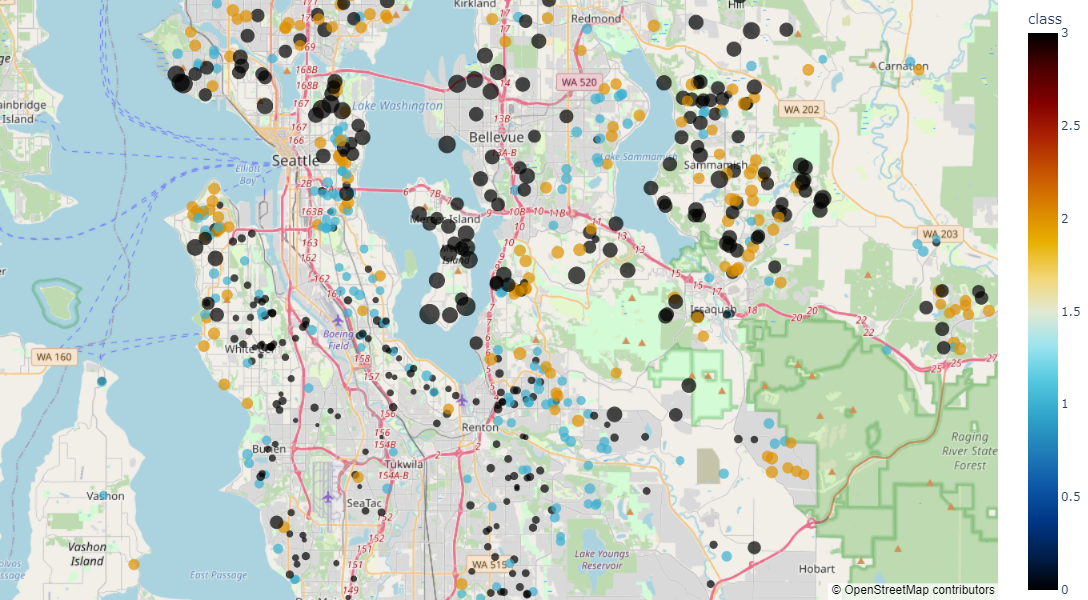

time: 2.36 s (started: 2022-07-31 15:46:38 +01:00)


In [ ]:
houses = df92[['id', 'lat', 'long', 'price', 'predictions']].copy()

# define class
for i in range( len( houses ) ):
    if houses.loc[i, 'price'] <= 300000:
        houses.loc[i, 'class'] = 0
        
    elif (houses.loc[i, 'price'] > 300000) & (houses.loc[i, 'price'] <= 460000 ):
        houses.loc[i, 'class'] = 1
        
    elif (houses.loc[i, 'price'] > 460000) & (houses.loc[i, 'price'] <= 645000 ):
        houses.loc[i, 'class'] = 2
        
    else:
        houses.loc[i, 'class'] = 3
        
        
houses['class'] =  houses['class'].astype( int )

fig = px.scatter_mapbox( houses, 
                         lat='lat', 
                         lon='long',
                         color='class', 
                         size='price', 
                         color_continuous_scale=px.colors.cyclical.IceFire,
                         size_max=15,
                         zoom=10 ) 

fig.update_layout( mapbox_style='open-street-map' )
fig.update_layout( height=600, margin={'r':0, 't':0, 'l':0, 'b':0} )
fig.show()

## 9.2. Total Performance

In [ ]:
df94 = df93[['price', 'predictions', 'worst_scenario', 'best_scenario', 'profit_worst_scn', 'profit_best_scn' ]].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df94['Values'] = df94['Values'].map('${:,.2f}'.format)

time: 31 ms (started: 2022-07-31 15:46:40 +01:00)


In [ ]:
df94

Scenario           Values
0             price  $115,672,352.00
1       predictions  $138,903,611.35
2    worst_scenario  $126,989,477.70
3     best_scenario  $150,817,745.00
4  profit_worst_scn   $11,317,125.70
5   profit_best_scn   $35,145,393.00

time: 16 ms (started: 2022-07-31 15:46:40 +01:00)


## 9.3. Machine Learning Performance

In [ ]:
df9['error'] = df9['price'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['price']

time: 0 ns (started: 2022-07-31 15:46:41 +01:00)


c:\Users\Natalia\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\Users\Natalia\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='predictions', ylabel='error'>

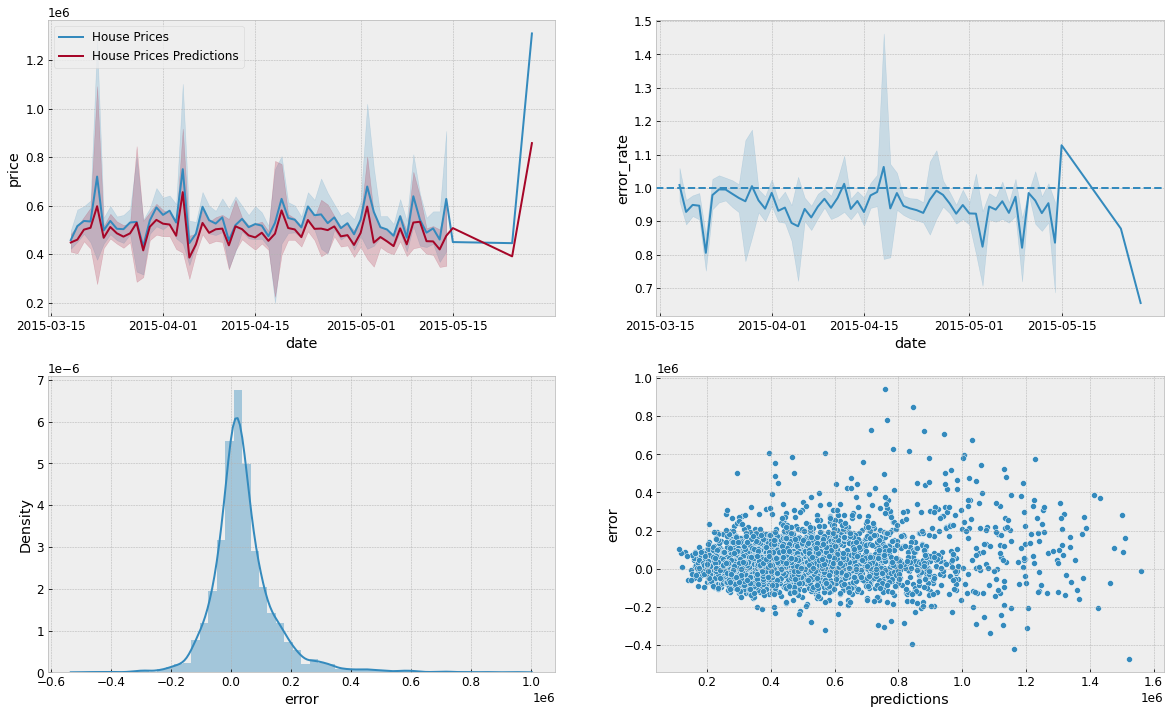

time: 10.1 s (started: 2022-07-31 15:46:41 +01:00)


In [ ]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='price', data=df9, label='House Prices')
sns.lineplot(x='date', y='predictions', data=df9, label='House Prices Predictions')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])



## 10.0. Deployment of model into production

In [ ]:
pickle.dump(rf_tuned, open("C:/Users/Natalia/Desktop/house_rocket/model/rf_tuned.pkl", "wb"))

time: 18.6 s (started: 2022-07-31 15:46:51 +01:00)
